<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/final_alzhmer_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!unzip '/content/drive/MyDrive/db_al/Q1 Dataset (3).zip'

Archive:  /content/drive/MyDrive/db_al/Q1 Dataset (3).zip
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153020345_13_S200932_I390347.jpg  
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153021214_26_S200932_I390347.jpg  
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153021345_25_S200932_I390347.jpg  
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153033221_29_S200932_I390347.jpg  
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153042580_27_S200932_I390347.jpg  
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI_006_S_4153_MR_Axial_T2-Star__br_raw_20130916153048335_30_S200932_I390347.jpg  
  inflating: Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/ADNI

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import itertools

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

یک دانه تصادفی برای اطمینان از تکرارپذیری نتایج استفاده می شود.
به عبارت دیگر، استفاده از این پارامتر اطمینان حاصل می کند که هرکسی که کد شما را دوباره اجرا می کند، دقیقا همان خروجی ها را دریافت می کند. تکرارپذیری یک مفهوم بسیار مهم در علم داده و سایر زمینه ها است

# Load Date

In [ ]:
data_dir = '/content/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

# Load data
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

images, labels = load_data(data_dir)
labels = np.where(labels == 'AD', 1, 0)
one_hot = np.zeros((labels.shape[0], 2))
one_hot[np.arange(labels.shape[0]), labels] = 1
labels = one_hot

## Split  the Data to Train, Validation, Test

In [ ]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

prevent issues such as biased models or poor generalization due to an imbalanced distribution of classes in the training and testing data.

> Add blockquote



## Display Class Distribution in Training Dataset Before Augmentation

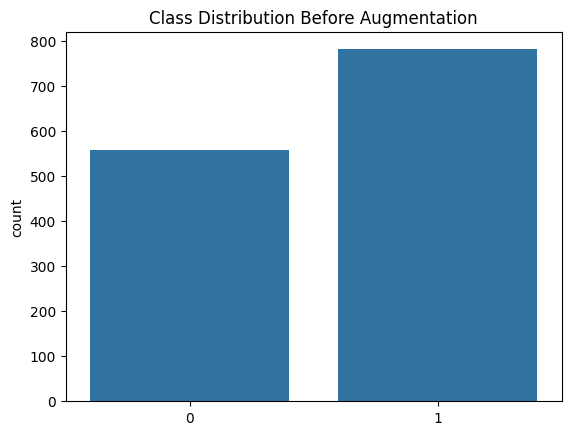

In [ ]:
# Display class distribution before augmentation
sns.countplot(x=np.argmax(y_train, 1))
plt.title('Class Distribution Before Augmentation')
plt.show()

## Implement Data Generators and Add Augmentation to Training Data

In [ ]:
batch_size = 64

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,#تصاویر را با زاویه 0.2 برش می‌دهد.
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' #برای پر کردن پیکسل‌های خالی ایجاد شده در اثر تقویت، از نزدیک‌ترین پیکسل استفاده می‌کند.

)
train_datagen_test = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_test = train_datagen_test.flow(X_train, y_train, batch_size=batch_size)

val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

## Display Class Distribution in Training Dataset After



>



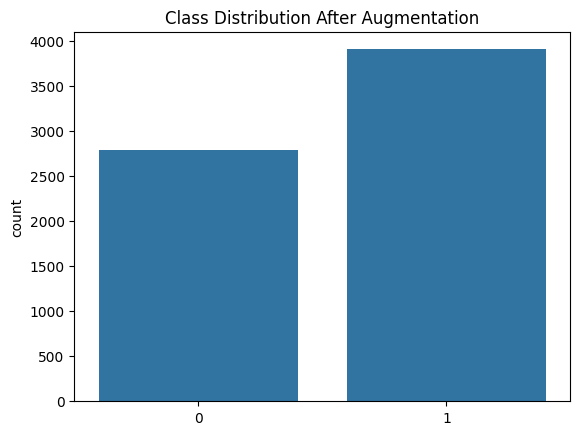

In [ ]:
augmented_images, _ = next(train_generator)

augmented_labels = []
for _ in range((len(y_train)*5 // batch_size)+1):
    _, batch_labels = next(train_generator)
    augmented_labels.extend(batch_labels)
sns.countplot(x=np.argmax(augmented_labels, 1))
plt.title('Class Distribution After Augmentation')
plt.show()

## Display Augmented Data

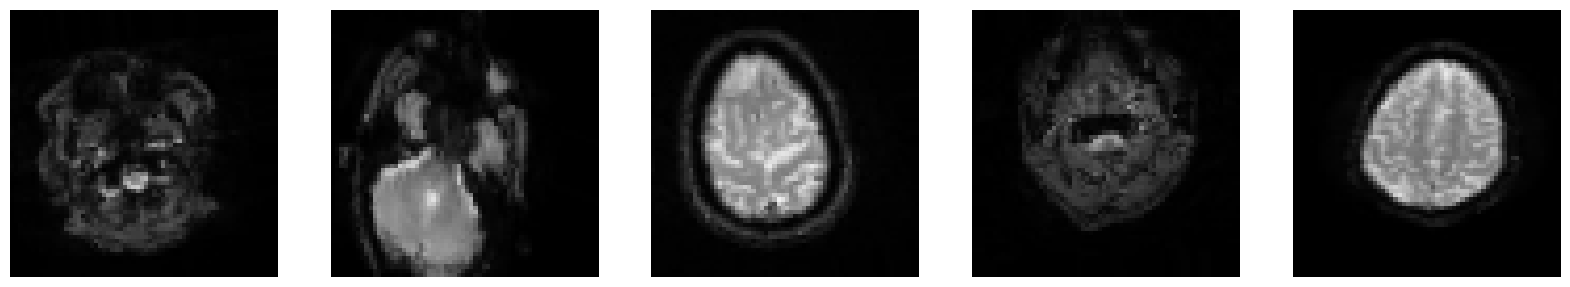

In [ ]:
# Display 5 random augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    random_index = np.random.randint(0, len(augmented_images))
    ax = axes[i]
    ax.imshow(augmented_images[random_index])
    ax.axis('off')
plt.show()

# Defining the Models

In [ ]:
# Define models

testing_model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

testing_model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

proposed_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

proposed_model_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

proposed_model_glorot = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

proposed_model_dropout_glorot = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

models = {
    "Testing Model 1": testing_model_1,
    "Testing Model 2": testing_model_2,
    "Proposed Model": proposed_model,
    "Proposed Model with Dropout": proposed_model_dropout,
    "Proposed Model with Glorot Initializer": proposed_model_glorot,
    "Proposed Model with Droupout and Glorot Initializer": proposed_model_dropout_glorot
}

# Creating Necessary Functions

In [ ]:
def compile_and_train(name, model, train_generator, val_generator, epochs=300):

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator)
    return history

def plot_history(name, history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(name)
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

def evaluate_and_plot_confusion_matrix(name, model, generator, y):
    test_loss, test_acc = model.evaluate(generator, verbose=0)

    Y_true = []
    generator.reset()
    for _ in range((len(y) // batch_size)+1):
        _, batch_labels = next(generator)
        Y_true.extend(batch_labels)
    Y_true = np.argmax(Y_true, 1)

    generator.reset()
    Y_pred = model.predict(generator)
    Y_pred_classes = np.argmax(Y_pred, 1)

    fpr, tpr, _ = roc_curve(Y_true, Y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name + ' Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    accuracy = accuracy_score(Y_true, Y_pred_classes)
    precision = precision_score(Y_true, Y_pred_classes)
    recall = recall_score(Y_true, Y_pred_classes)
    f1 = f1_score(Y_true, Y_pred_classes)
    print(f'Accuracy: {accuracy*100:.2f}')
    print(f'Precision: {precision*100:.2f}')
    print(f'Recall: {recall*100:.2f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {roc_auc:.3f}')
    print(f"Loss: {test_loss:.3f}")

# Training and Evaluating "Proposed Model", "Testing Model 1" and "Testing Model 2"

## Train and Evaluate Testing Model 1

Training Testing Model 1...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5579
Epoch 1: val_loss improved from inf to 0.66845, saving model to best_Testing Model 1.h5
21/21 [==============================] - 3s 91ms/step - loss: 0.6889 - accuracy: 0.5579 - val_loss: 0.6685 - val_accuracy: 0.5839
Epoch 2/300
 1/21 [>.............................] - ETA: 1s - loss: 0.6922 - accuracy: 0.5469

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.5818
Epoch 2: val_loss improved from 0.66845 to 0.66837, saving model to best_Testing Model 1.h5
21/21 [==============================] - 2s 117ms/step - loss: 0.6730 - accuracy: 0.5818 - val_loss: 0.6684 - val_accuracy: 0.5839
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.6012
Epoch 3: val_loss improved from 0.66837 to 0.62788, saving model to best_Testing Model 1.h5
21/21 [==============================] - 2s 111ms/step - loss: 0.6572 - accuracy: 0.6012 - val_loss: 0.6279 - val_accuracy: 0.6107
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.6199
Epoch 4: val_loss did not improve from 0.62788
21/21 [==============================] - 2s 80ms/step - loss: 0.6400 - accuracy: 0.6199 - val_loss: 0.6605 - val_accuracy: 0.5839
Epoch 5/300
21/21 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.5930
Epoch 5: 

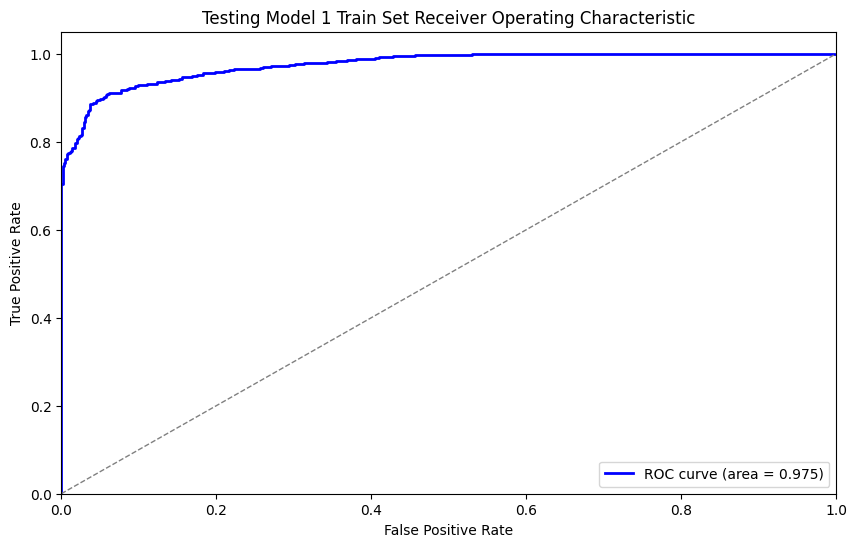

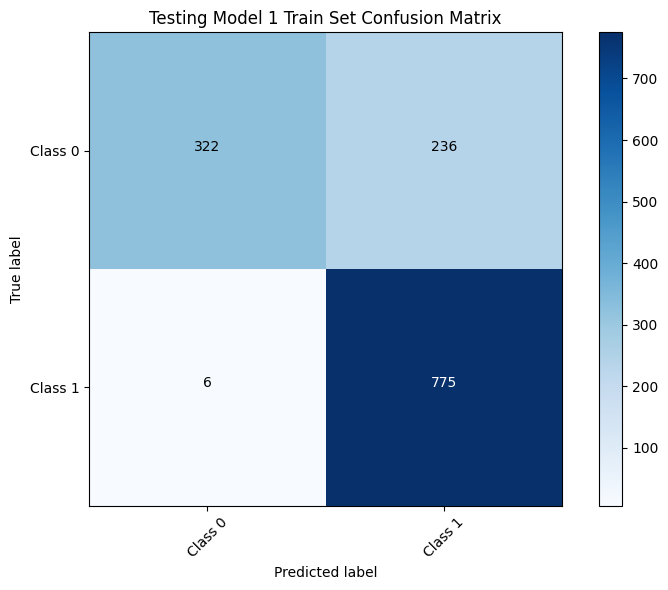

Accuracy: 81.93
Precision: 76.66
Recall: 99.23
F1 Score: 0.865
AUC: 0.975
Loss: 0.474
Evaluating Testing Model 1 on Validation set...
Test accuracy: 0.7785235047340393 Test loss: 0.8440542817115784
3/3 [==============================] - 0s 7ms/step


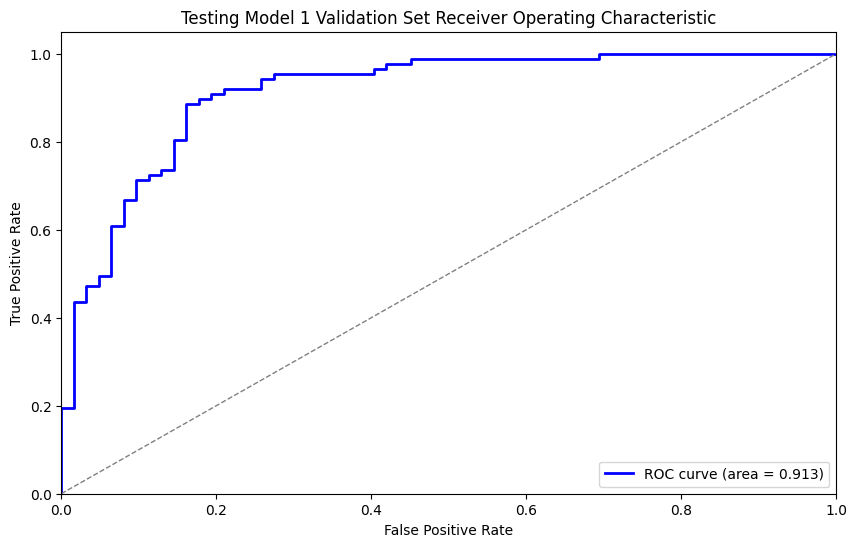

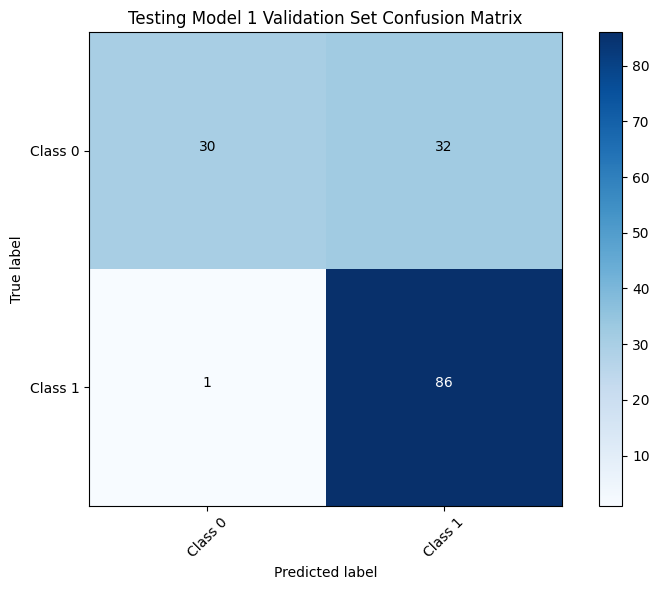

Accuracy: 77.85
Precision: 72.88
Recall: 98.85
F1 Score: 0.839
AUC: 0.913
Loss: 0.844
Evaluating Testing Model 1 on Test set...
Test accuracy: 0.759036123752594 Test loss: 0.7585859894752502
3/3 [==============================] - 0s 14ms/step


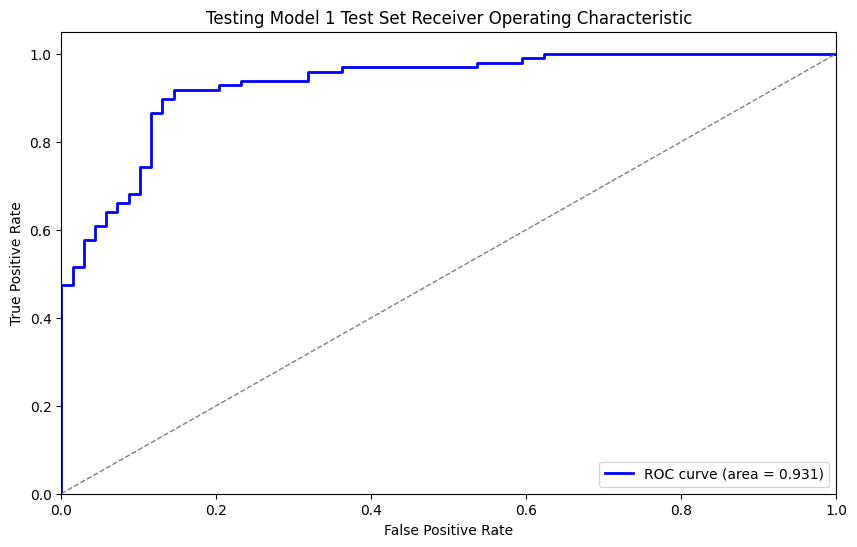

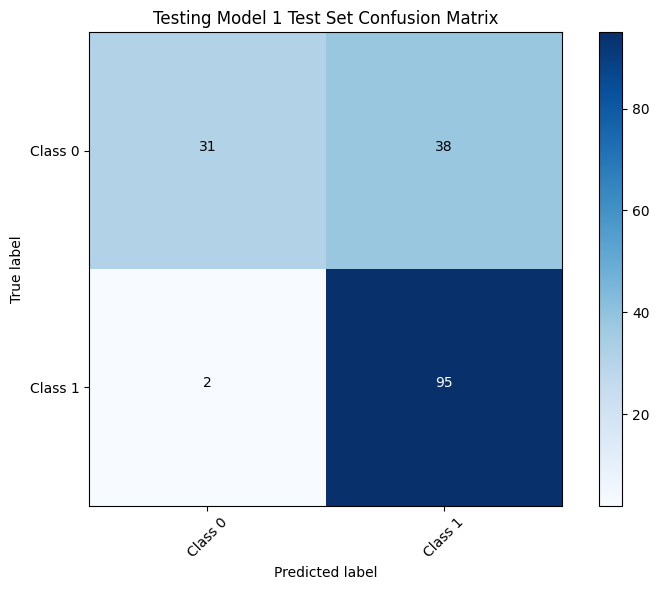

Accuracy: 75.90
Precision: 71.43
Recall: 97.94
F1 Score: 0.826
AUC: 0.931
Loss: 0.759
Plotting history for Testing Model 1...


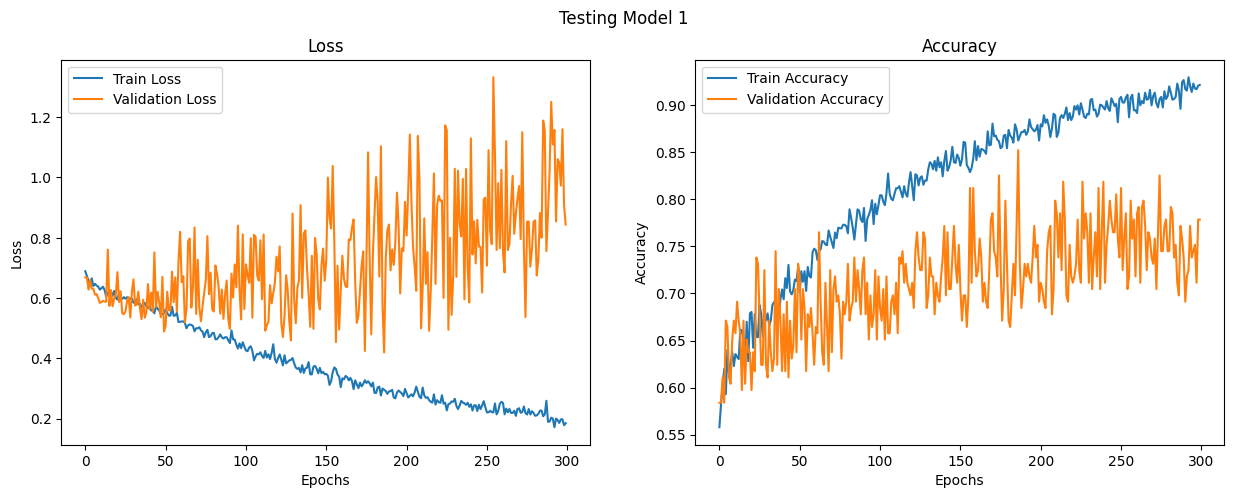

In [ ]:
model_name = 'Testing Model 1'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name, model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

## Train and Evaluate Testing Model 2

Training Testing Model 2...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.5855
Epoch 1: val_loss improved from inf to 0.66728, saving model to best_Testing Model 2.h5
21/21 [==============================] - 45s 99ms/step - loss: 0.6784 - accuracy: 0.5855 - val_loss: 0.6673 - val_accuracy: 0.6242


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/300
21/21 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6057
Epoch 2: val_loss improved from 0.66728 to 0.66552, saving model to best_Testing Model 2.h5
21/21 [==============================] - 2s 86ms/step - loss: 0.6606 - accuracy: 0.6057 - val_loss: 0.6655 - val_accuracy: 0.6174
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6042
Epoch 3: val_loss improved from 0.66552 to 0.63309, saving model to best_Testing Model 2.h5
21/21 [==============================] - 3s 136ms/step - loss: 0.6543 - accuracy: 0.6042 - val_loss: 0.6331 - val_accuracy: 0.6779
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.6206
Epoch 4: val_loss improved from 0.63309 to 0.60250, saving model to best_Testing Model 2.h5
21/21 [==============================] - 2s 106ms/step - loss: 0.6463 - accuracy: 0.6206 - val_loss: 0.6025 - val_accuracy: 0.6510
Epoch 5/300
21/21 [============================

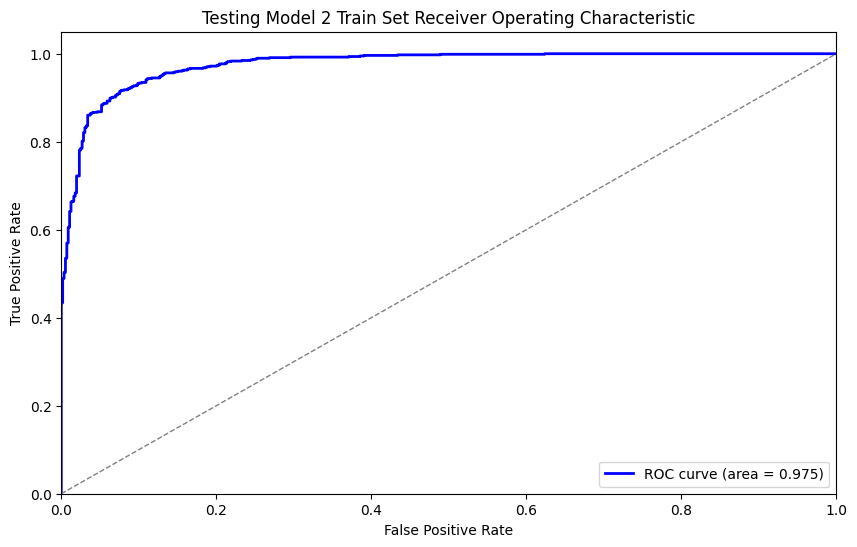

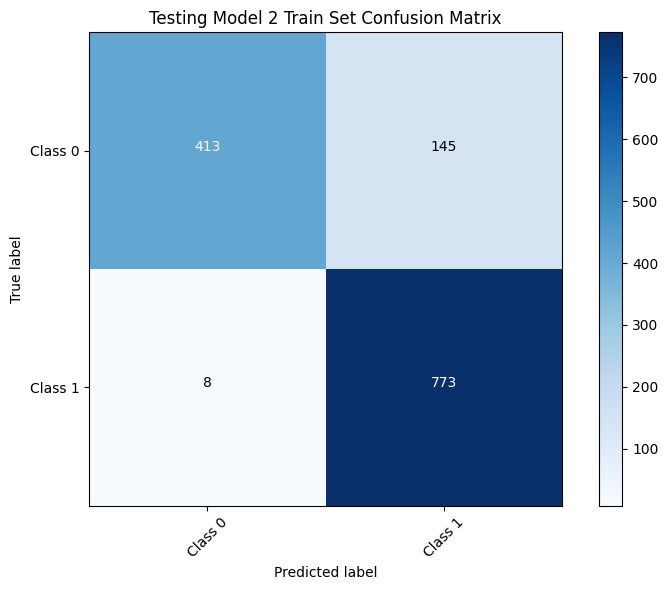

Accuracy: 88.57
Precision: 84.20
Recall: 98.98
F1 Score: 0.910
AUC: 0.975
Loss: 0.414
Evaluating Testing Model 2 on Validation set...
Test accuracy: 0.791946291923523 Test loss: 0.823567807674408
3/3 [==============================] - 0s 6ms/step


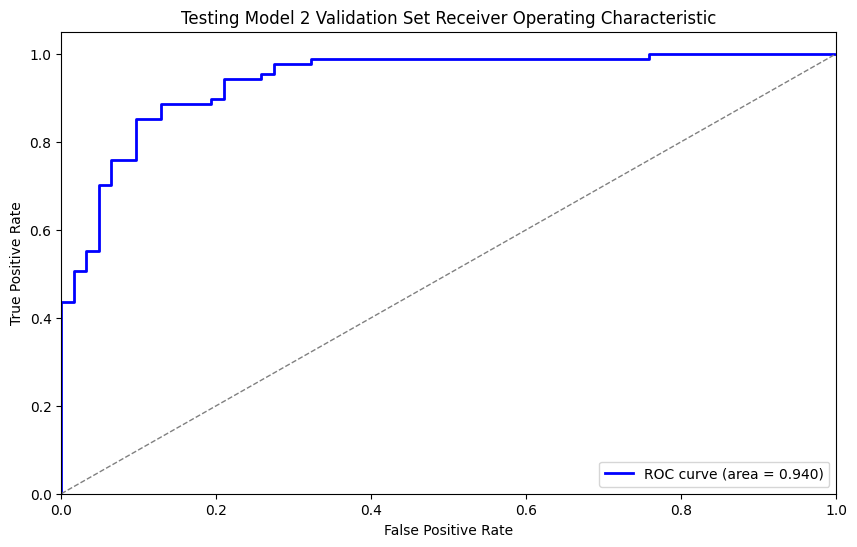

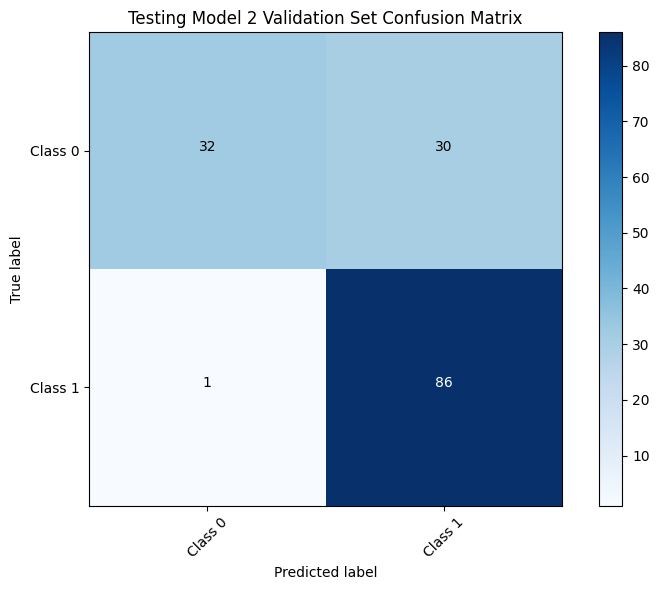

Accuracy: 79.19
Precision: 74.14
Recall: 98.85
F1 Score: 0.847
AUC: 0.940
Loss: 0.824
Evaluating Testing Model 2 on Test set...
Test accuracy: 0.8373494148254395 Test loss: 0.6958634257316589
3/3 [==============================] - 0s 7ms/step


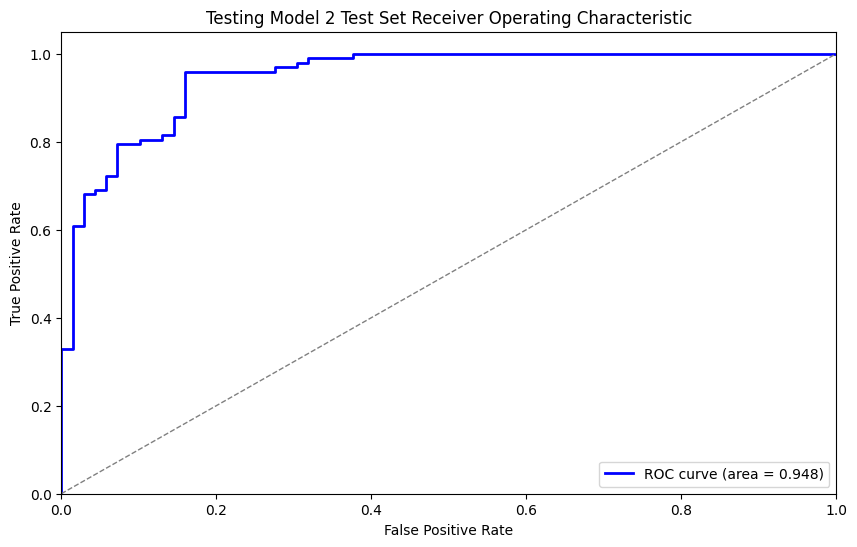

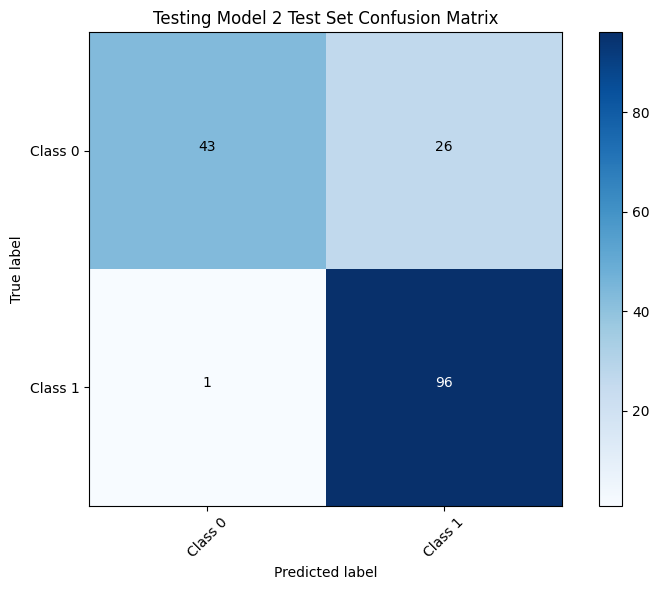

Accuracy: 83.73
Precision: 78.69
Recall: 98.97
F1 Score: 0.877
AUC: 0.948
Loss: 0.696
Plotting history for Testing Model 2...


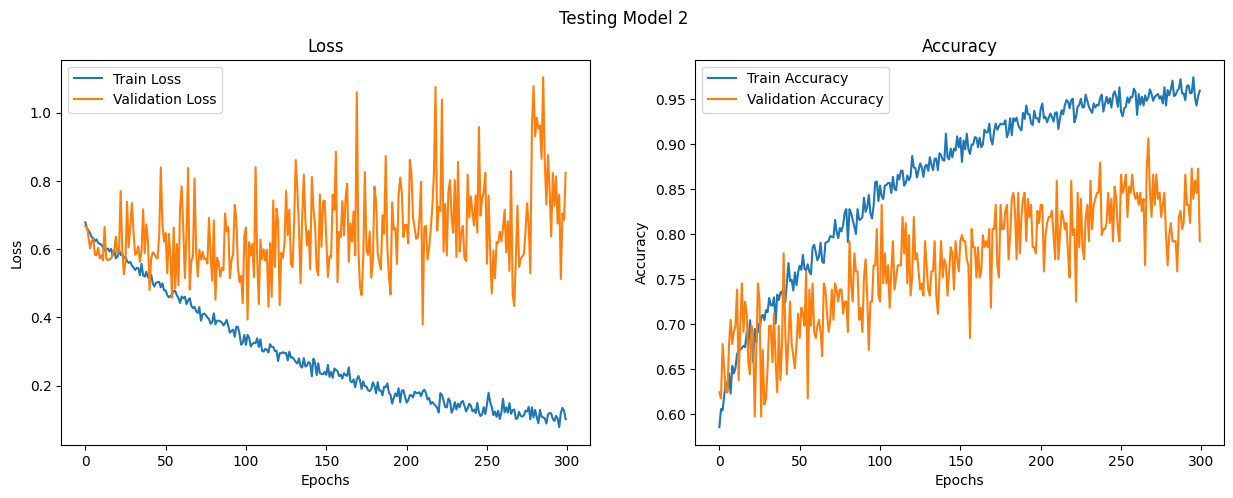

In [ ]:
model_name = 'Testing Model 2'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name, model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

## Train and Evaluate Proposed Model

Training Proposed Model...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5855
Epoch 1: val_loss improved from inf to 0.67852, saving model to best_Proposed Model.h5
21/21 [==============================] - 5s 102ms/step - loss: 0.6882 - accuracy: 0.5855 - val_loss: 0.6785 - val_accuracy: 0.5839


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/300
21/21 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.5833
Epoch 2: val_loss did not improve from 0.67852
21/21 [==============================] - 2s 84ms/step - loss: 0.6725 - accuracy: 0.5833 - val_loss: 0.6946 - val_accuracy: 0.5839
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.5855
Epoch 3: val_loss did not improve from 0.67852
21/21 [==============================] - 2s 87ms/step - loss: 0.6662 - accuracy: 0.5855 - val_loss: 0.6843 - val_accuracy: 0.5570
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5795
Epoch 4: val_loss improved from 0.67852 to 0.64891, saving model to best_Proposed Model.h5
21/21 [==============================] - 2s 93ms/step - loss: 0.6754 - accuracy: 0.5795 - val_loss: 0.6489 - val_accuracy: 0.5839
Epoch 5/300
21/21 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.5945
Epoch 5: val_loss improved from 0.64891 to 0.

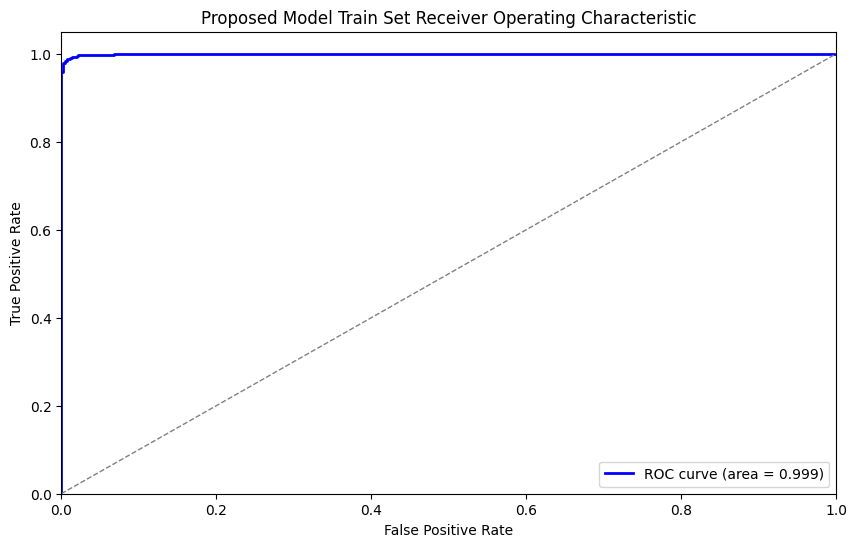

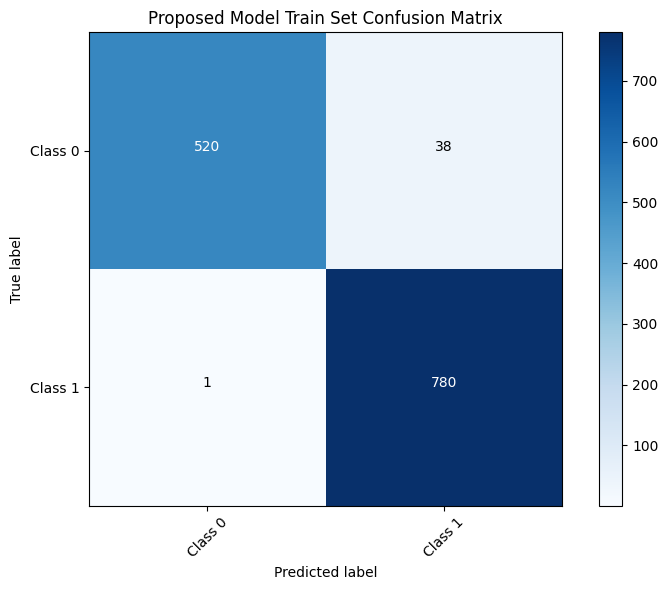

Accuracy: 97.09
Precision: 95.35
Recall: 99.87
F1 Score: 0.976
AUC: 0.999
Loss: 0.079
Evaluating Proposed Model on Validation set...
Test accuracy: 0.9194630980491638 Test loss: 0.2975606620311737
3/3 [==============================] - 0s 12ms/step


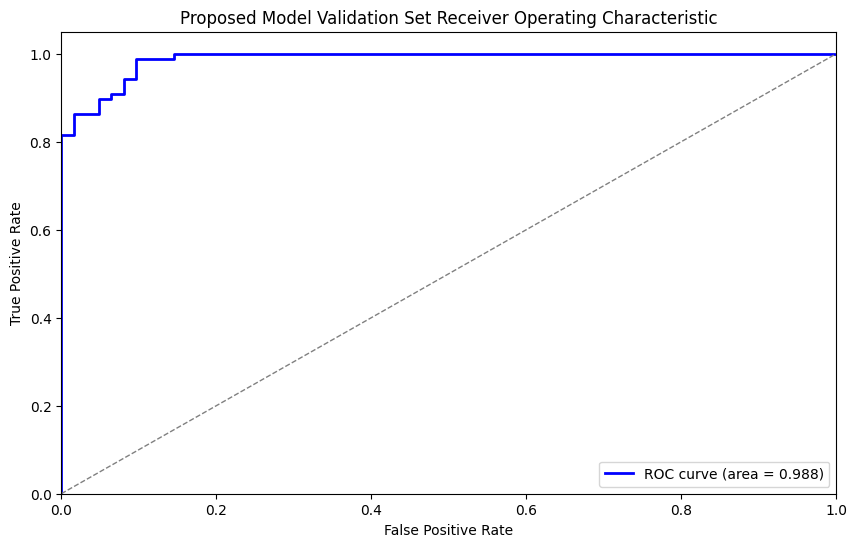

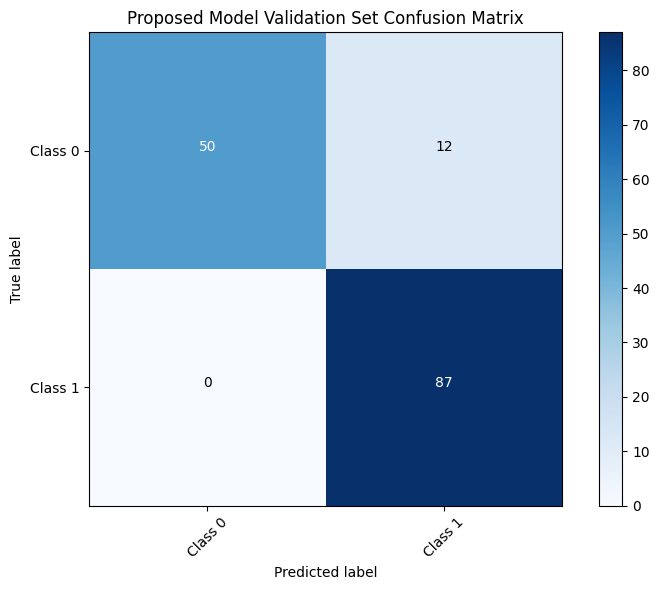

Accuracy: 91.95
Precision: 87.88
Recall: 100.00
F1 Score: 0.935
AUC: 0.988
Loss: 0.298
Evaluating Proposed Model on Test set...
Test accuracy: 0.9096385836601257 Test loss: 0.40054818987846375
3/3 [==============================] - 0s 9ms/step


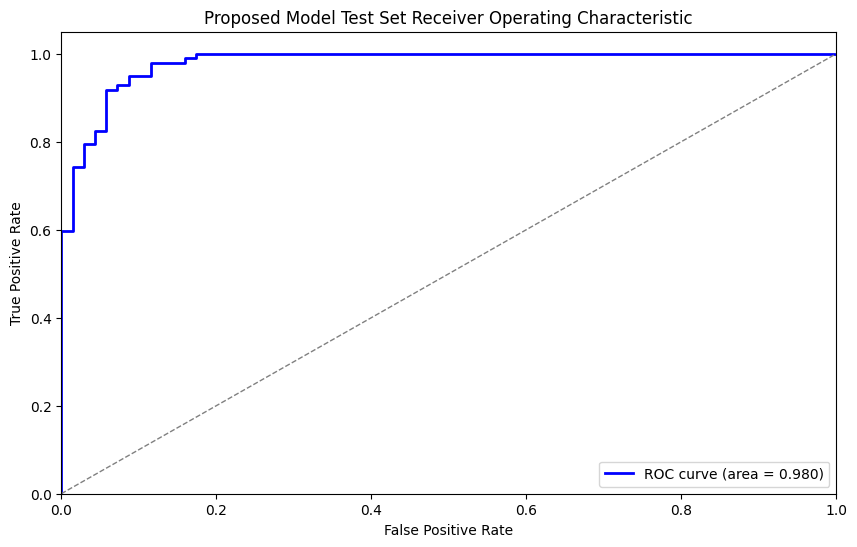

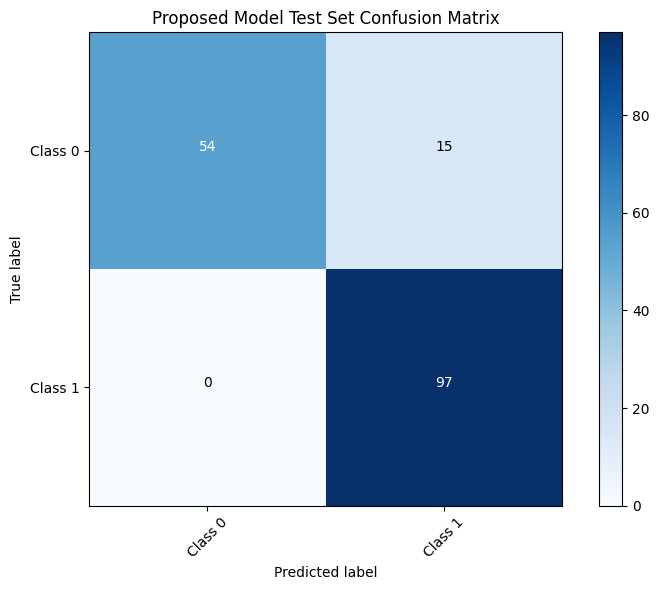

Accuracy: 90.96
Precision: 86.61
Recall: 100.00
F1 Score: 0.928
AUC: 0.980
Loss: 0.401
Plotting history for Proposed Model...


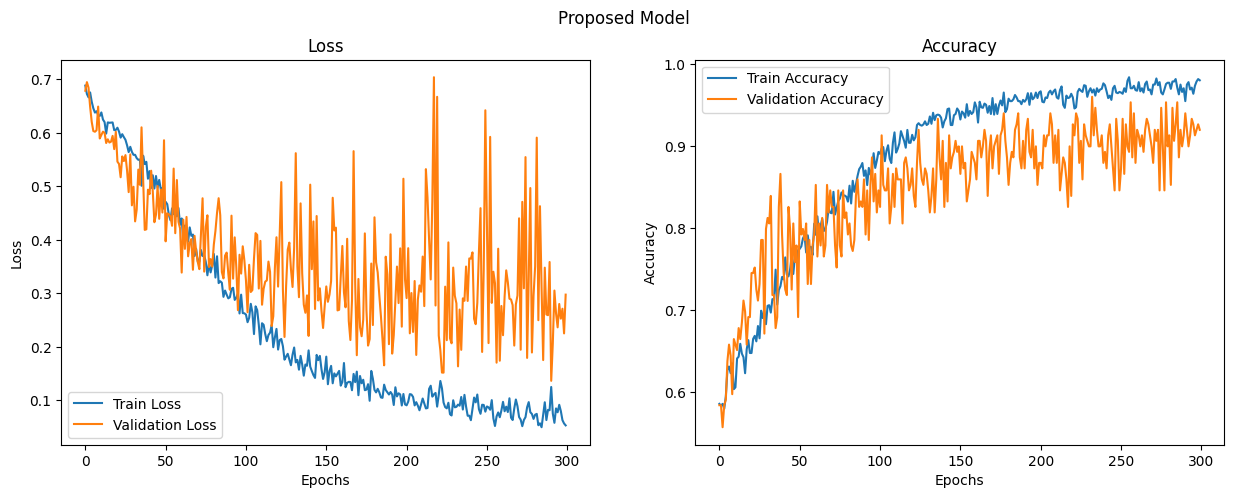

In [ ]:
model_name = 'Proposed Model'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name, model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

# Train and Evaluate Proposed Model with Dropout

Training Proposed Model with Dropout...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5676
Epoch 1: val_loss improved from inf to 0.66937, saving model to best_Proposed Model with Dropout.h5
21/21 [==============================] - 11s 201ms/step - loss: 0.6813 - accuracy: 0.5676 - val_loss: 0.6694 - val_accuracy: 0.5839
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.5825
Epoch 2: val_loss improved from 0.66937 to 0.65834, saving model to best_Proposed Model with Dropout.h5
21/21 [==============================] - 2s 92ms/step - loss: 0.6722 - accuracy: 0.5825 - val_loss: 0.6583 - val_accuracy: 0.5839
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.5975
Epoch 3: val_loss improved from 0.65834 to 0.65516, saving model to best_Proposed Model with Dropout.h5
21/21 [==============================] - 2s 94ms/step - loss: 0.6667 - accuracy: 0.5975 - val_loss: 0.6552 - val_accuracy: 0.5839
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6139
Epoch 4: val_loss improved from 0.65516 to 0.63376, saving model to best_Proposed Model with Dropout.h5
21/21 [==============================] - 2s 96ms/step - loss: 0.6505 - accuracy: 0.6139 - val_loss: 0.6338 - val_accuracy: 0.6644
Epoch 5/300
21/21 [======

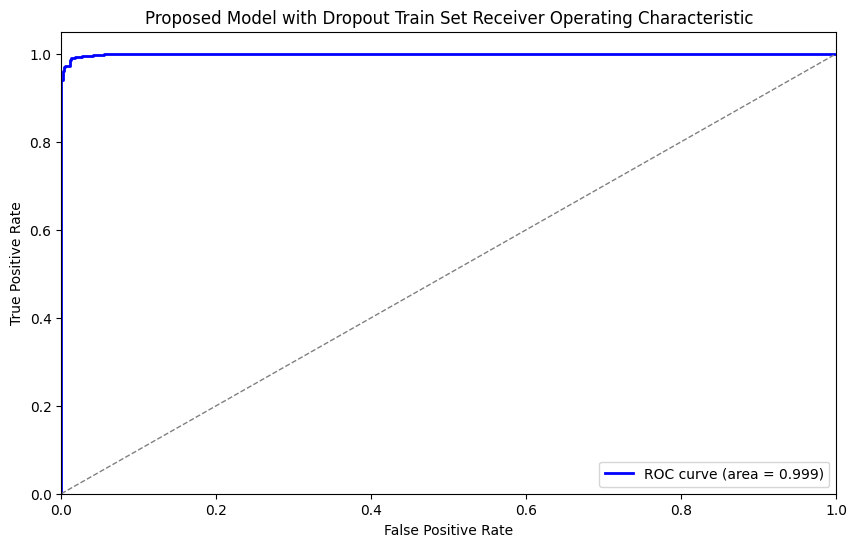

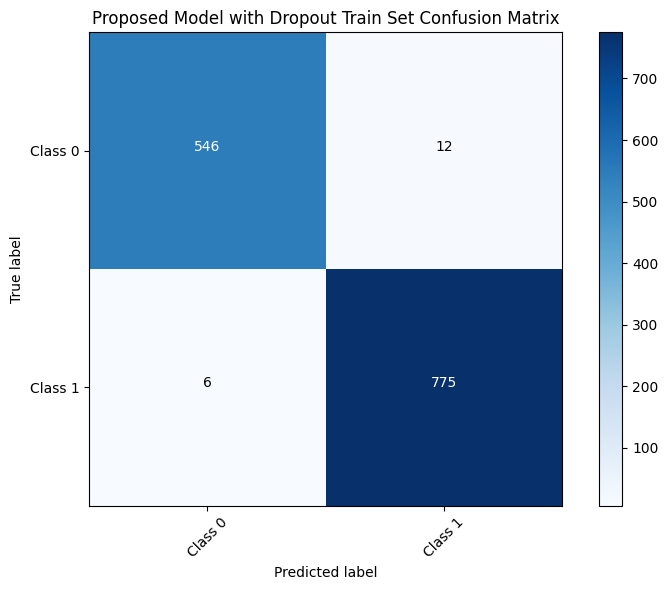

Accuracy: 98.66
Precision: 98.48
Recall: 99.23
F1 Score: 0.989
AUC: 0.999
Loss: 0.038
Evaluating Proposed Model with Dropout on Validation set...
Test accuracy: 0.9664429426193237 Test loss: 0.14348207414150238
3/3 [==============================] - 0s 8ms/step


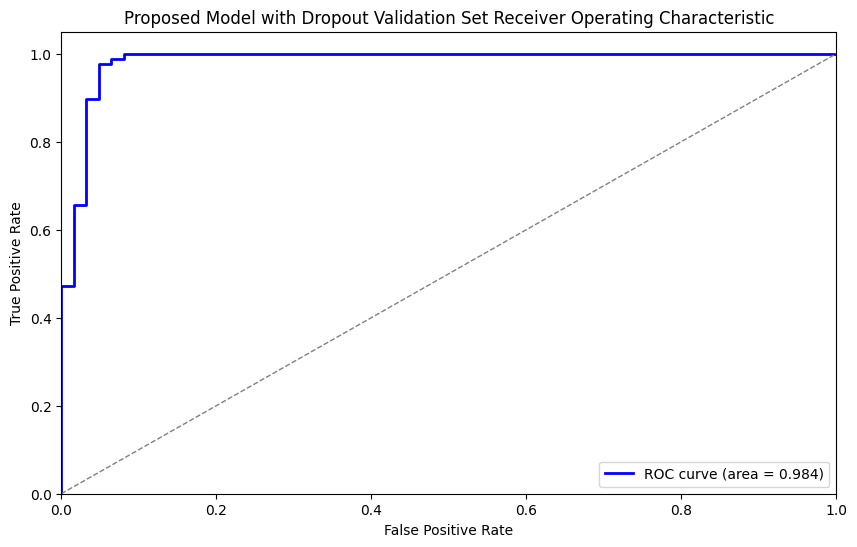

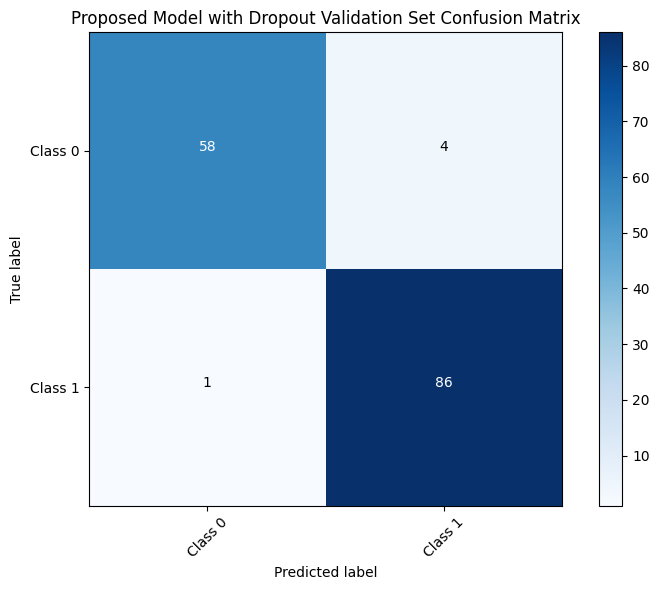

Accuracy: 96.64
Precision: 95.56
Recall: 98.85
F1 Score: 0.972
AUC: 0.984
Loss: 0.143
Evaluating Proposed Model with Dropout on Test set...
Test accuracy: 0.9397590160369873 Test loss: 0.20804879069328308
3/3 [==============================] - 0s 11ms/step


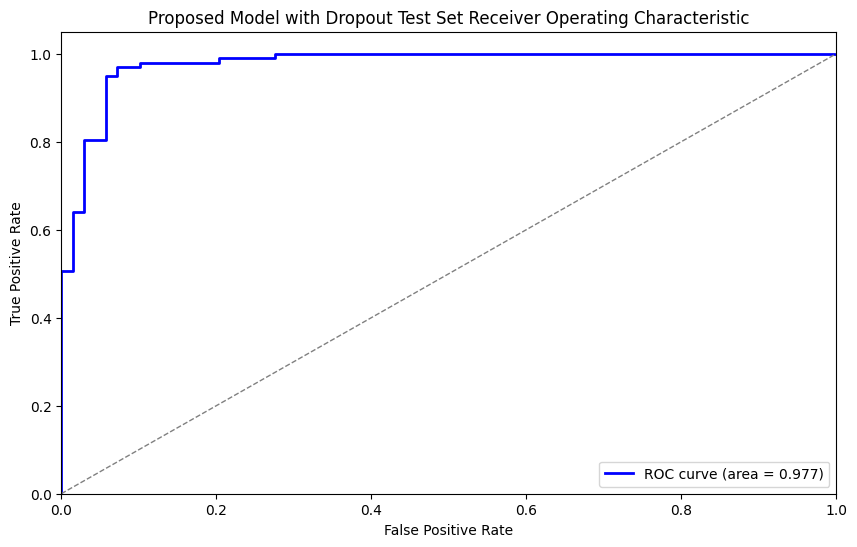

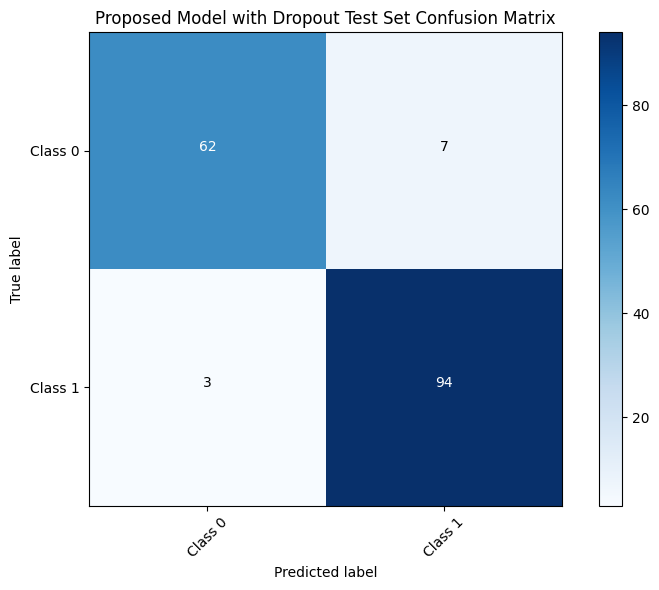

Accuracy: 93.98
Precision: 93.07
Recall: 96.91
F1 Score: 0.949
AUC: 0.977
Loss: 0.208
Plotting history for Proposed Model with Dropout...


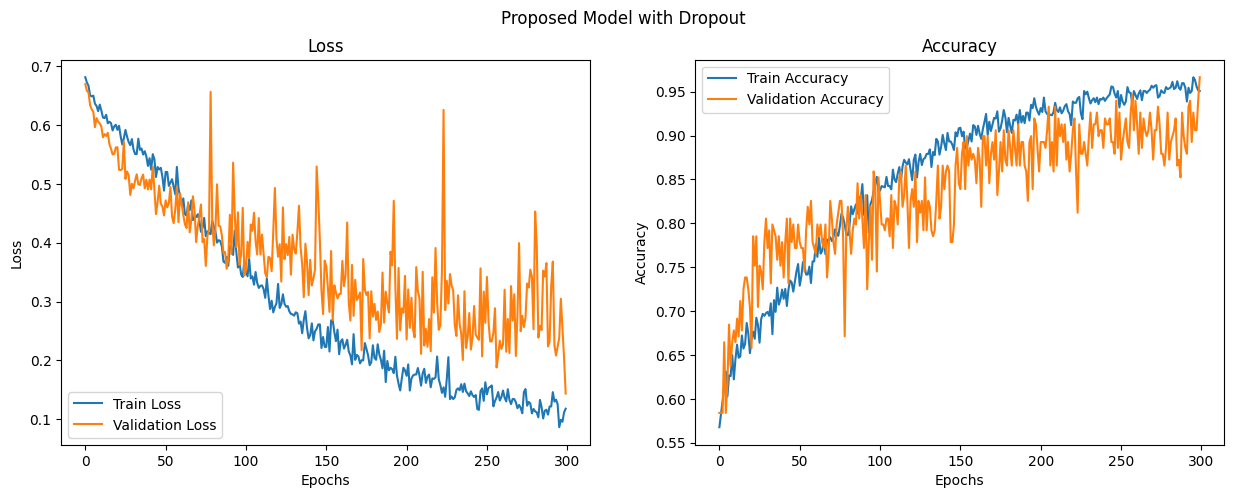

In [ ]:
model_name = 'Proposed Model with Dropout'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name, model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

# Train and Evaluate Proposed Model with Glorot Initializer

Training Proposed Model with Glorot Initializer...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5743
Epoch 1: val_loss improved from inf to 0.67080, saving model to best_Proposed Model with Glorot Initializer.h5
21/21 [==============================] - 4s 91ms/step - loss: 0.6804 - accuracy: 0.5743 - val_loss: 0.6708 - val_accuracy: 0.5839
Epoch 2/300
 1/21 [>.............................] - ETA: 2s - loss: 0.6899 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.5930
Epoch 2: val_loss did not improve from 0.67080
21/21 [==============================] - 2s 86ms/step - loss: 0.6691 - accuracy: 0.5930 - val_loss: 0.6733 - val_accuracy: 0.5839
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.5840
Epoch 3: val_loss improved from 0.67080 to 0.65412, saving model to best_Proposed Model with Glorot Initializer.h5
21/21 [==============================] - 3s 138ms/step - loss: 0.6746 - accuracy: 0.5840 - val_loss: 0.6541 - val_accuracy: 0.5906
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6206
Epoch 4: val_loss improved from 0.65412 to 0.64386, saving model to best_Proposed Model with Glorot Initializer.h5
21/21 [==============================] - 2s 92ms/step - loss: 0.6475 - accuracy: 0.6206 - val_loss: 0.6439 - val_accuracy: 0.6309
Epoch 5/300
21/21 [==============================] - ETA: 0

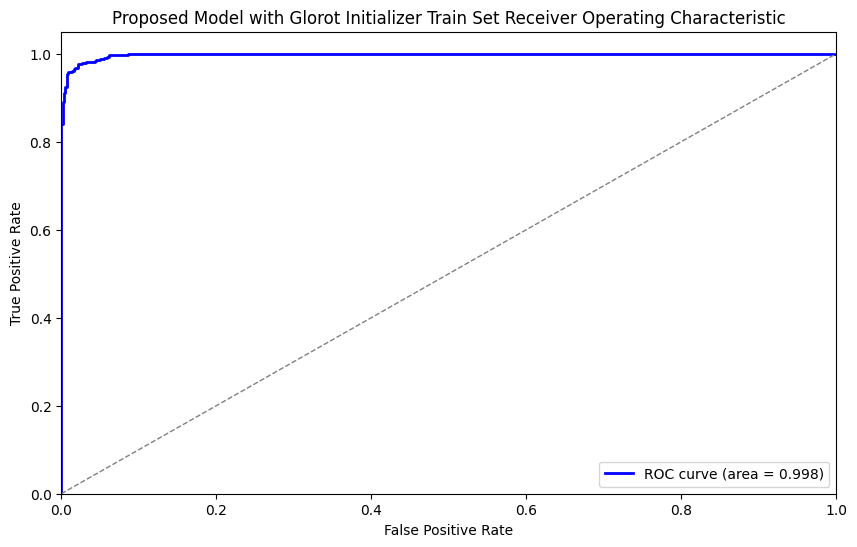

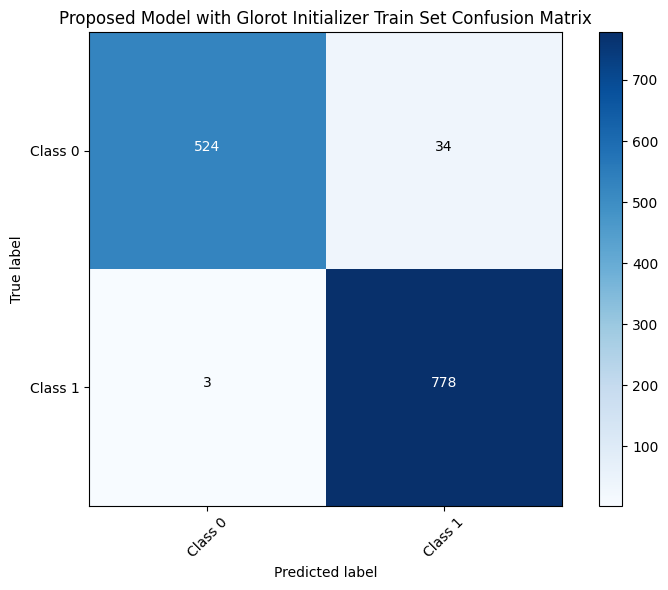

Accuracy: 97.24
Precision: 95.81
Recall: 99.62
F1 Score: 0.977
AUC: 0.998
Loss: 0.078
Evaluating Proposed Model with Glorot Initializer on Validation set...
Test accuracy: 0.8926174640655518 Test loss: 0.2809636890888214
3/3 [==============================] - 0s 7ms/step


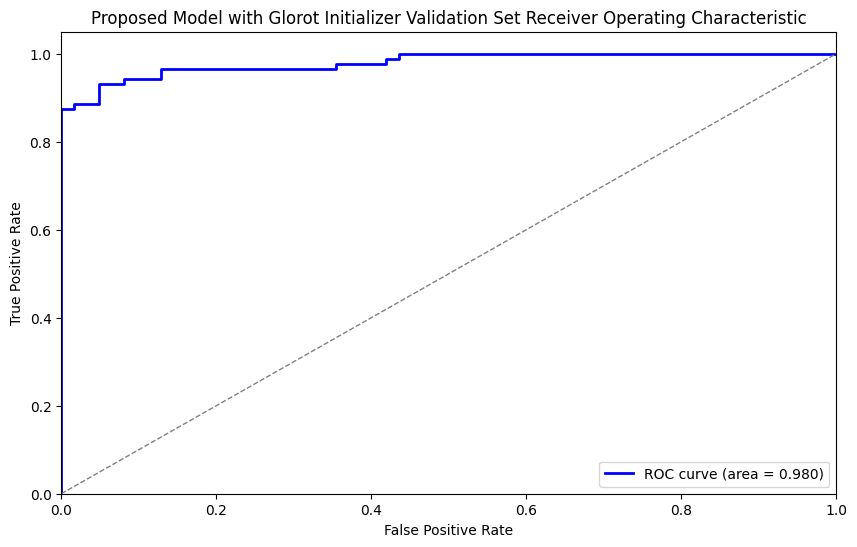

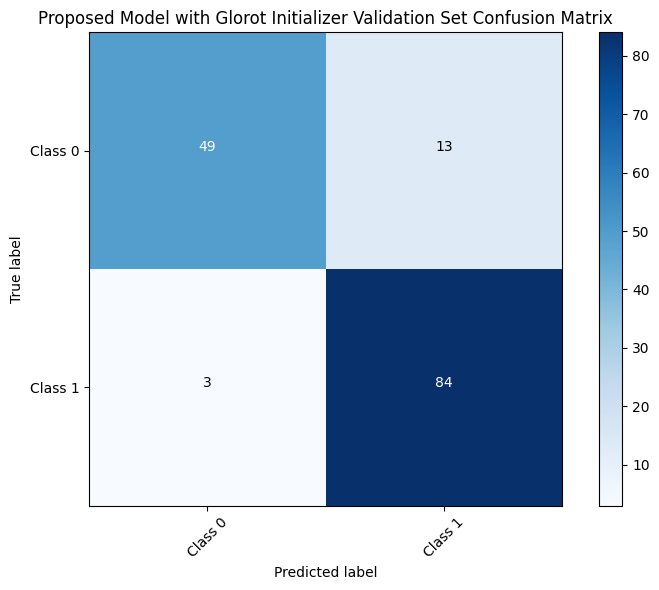

Accuracy: 89.26
Precision: 86.60
Recall: 96.55
F1 Score: 0.913
AUC: 0.980
Loss: 0.281
Evaluating Proposed Model with Glorot Initializer on Test set...
Test accuracy: 0.9156626462936401 Test loss: 0.26680752635002136
3/3 [==============================] - 0s 7ms/step


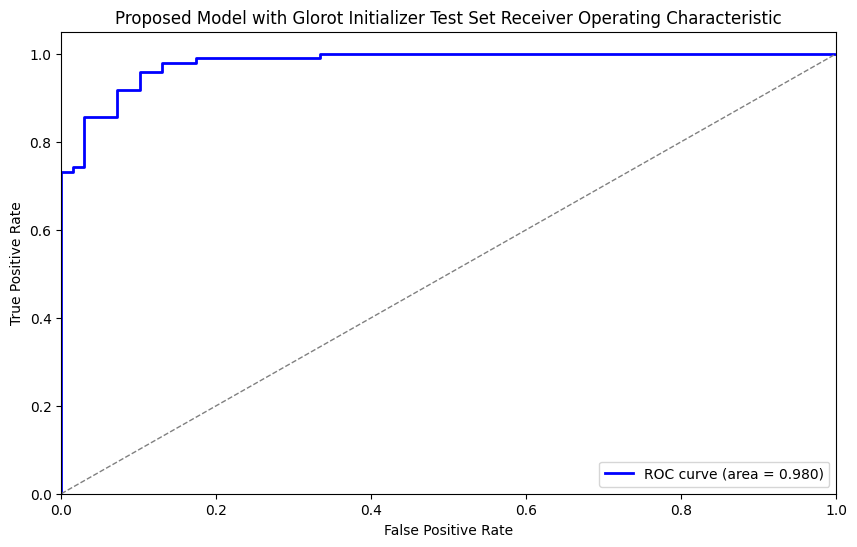

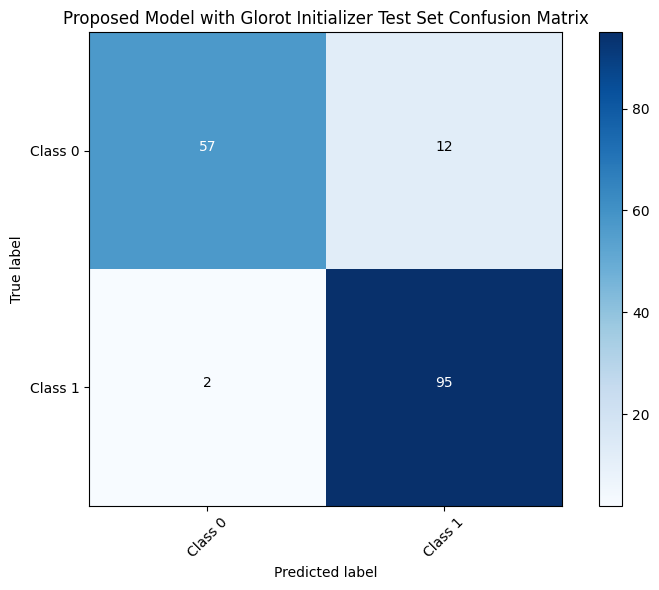

Accuracy: 91.57
Precision: 88.79
Recall: 97.94
F1 Score: 0.931
AUC: 0.980
Loss: 0.267
Plotting history for Proposed Model with Glorot Initializer...


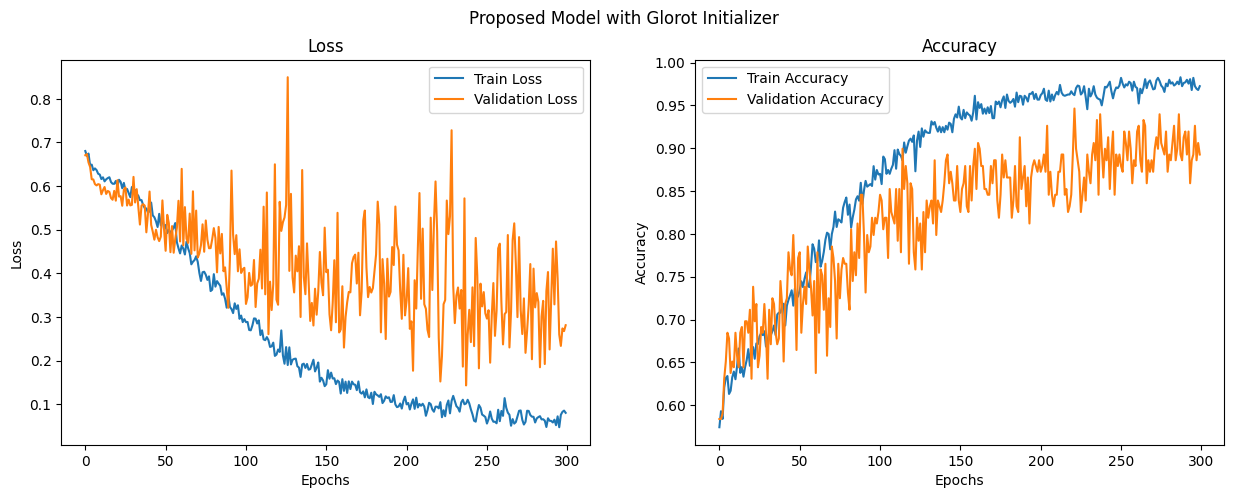

Training Proposed Model with Glorot Initializer...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9701
Epoch 1: val_loss improved from inf to 0.56162, saving model to best_Proposed Model with Glorot Initializer.h5
21/21 [==============================] - 4s 112ms/step - loss: 0.0791 - accuracy: 0.9701 - val_loss: 0.5616 - val_accuracy: 0.8389
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9671
Epoch 2: val_loss improved from 0.56162 to 0.30235, saving model to best_Proposed Model with Glorot Initializer.h5
21/21 [==============================] - 3s 149ms/step - loss: 0.0846 - accuracy: 0.9671 - val_loss: 0.3024 - val_accuracy: 0.9329
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9806
Epoch 3: val_loss improved from 0.30235 to 0.18908, saving model to best_Proposed Model with Glorot Initializer.h5
21/21 [==============================] - 2s 92ms/step - loss: 0.0570 - accuracy: 0.9806 - val_loss: 0.1891 - val_accuracy: 0.9530
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9768
Epoch 4: val_loss did not improve from 0.18908
21/21 [==============================] - 2s 88ms/step - loss: 0.0615 - accuracy: 0.9768 - val_loss: 0.4162 - val_accuracy: 0.8792
Epoch 5/300
21/21 [==============================] - ETA: 0

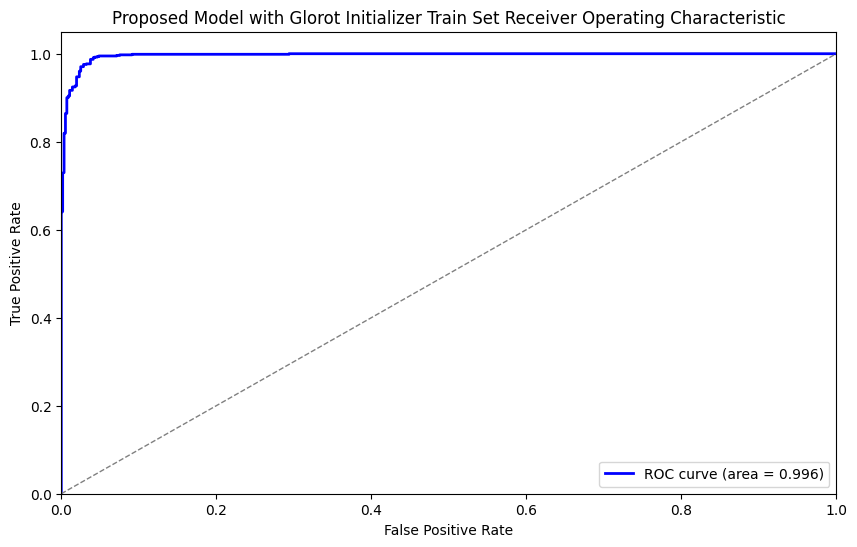

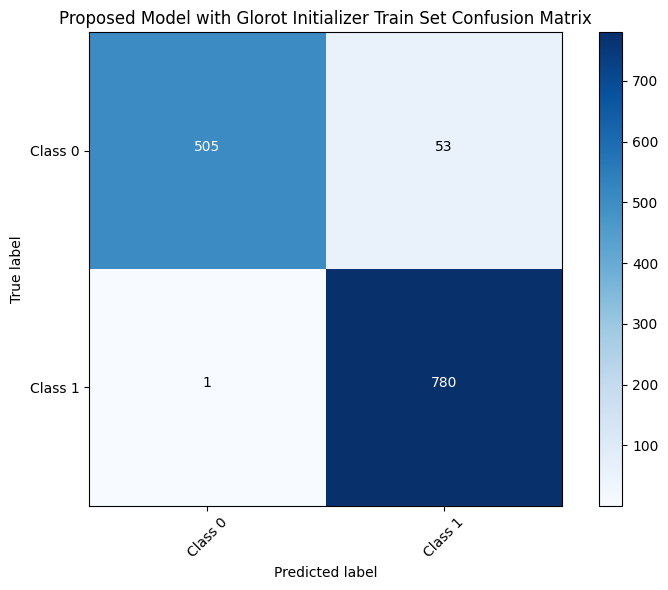

Accuracy: 95.97
Precision: 93.64
Recall: 99.87
F1 Score: 0.967
AUC: 0.996
Loss: 0.180
Evaluating Proposed Model with Glorot Initializer on Validation set...
Test accuracy: 0.8590604066848755 Test loss: 0.6365509629249573
3/3 [==============================] - 0s 12ms/step


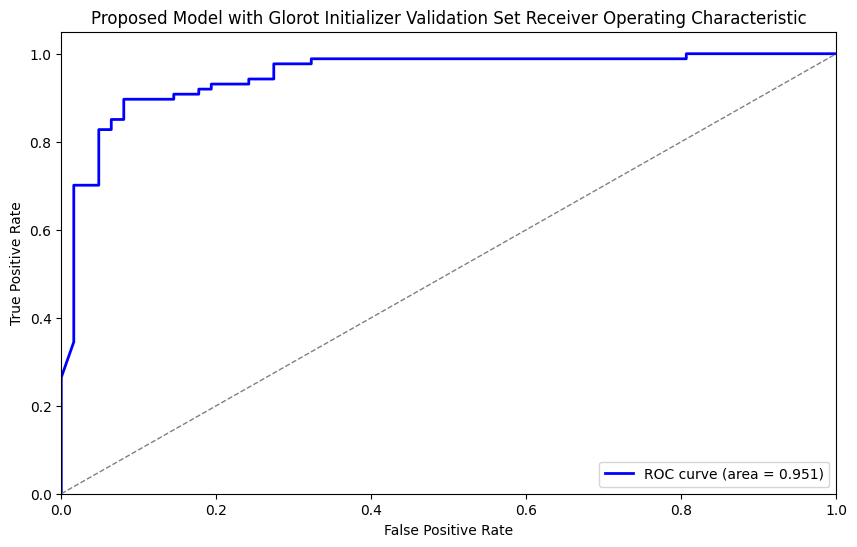

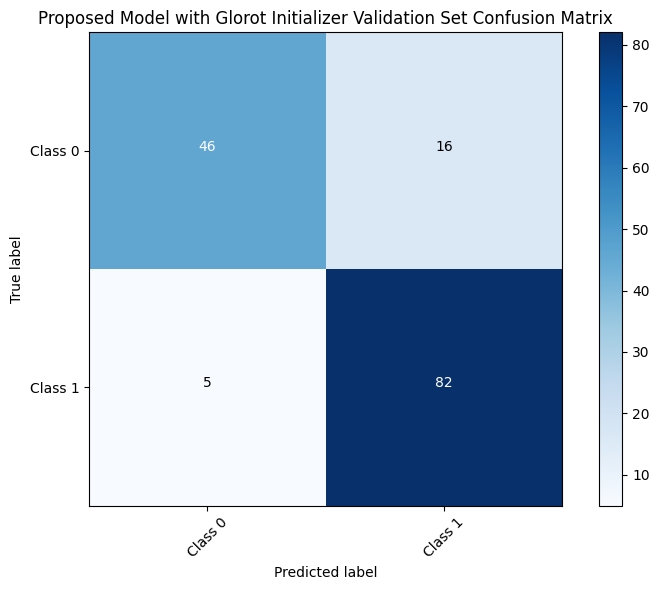

Accuracy: 85.91
Precision: 83.67
Recall: 94.25
F1 Score: 0.886
AUC: 0.951
Loss: 0.637
Evaluating Proposed Model with Glorot Initializer on Test set...
Test accuracy: 0.8313252925872803 Test loss: 0.8459726572036743
3/3 [==============================] - 0s 8ms/step


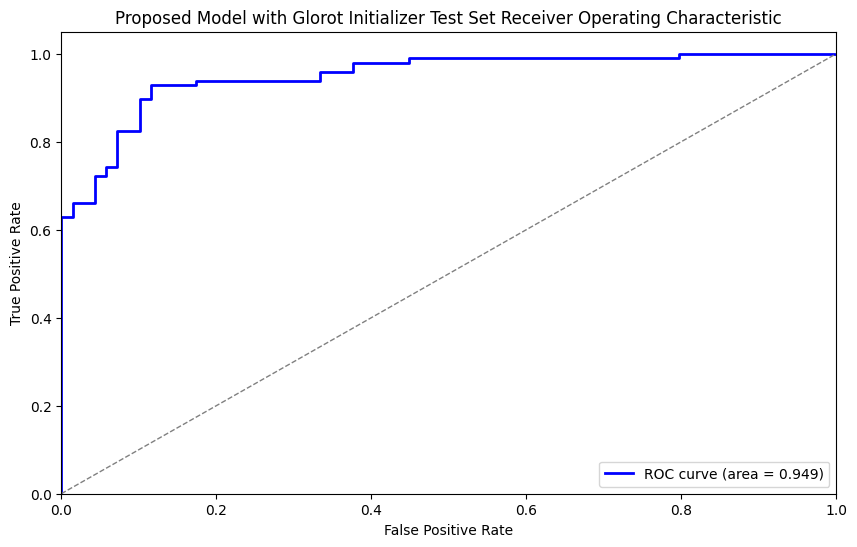

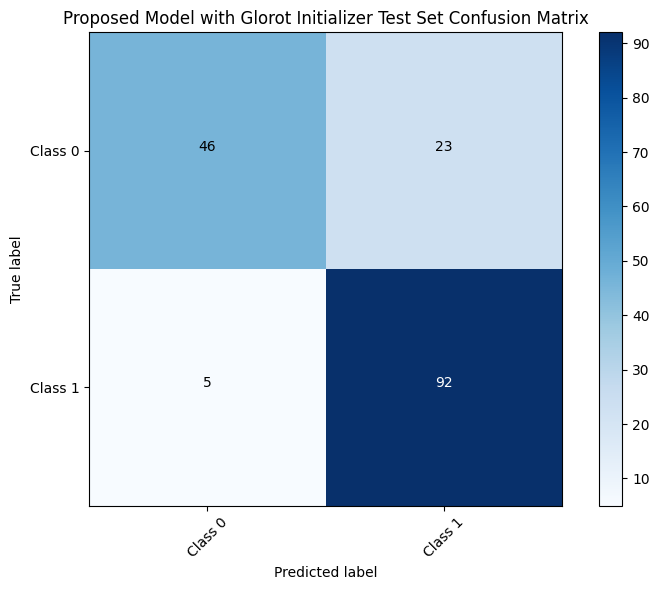

Accuracy: 83.13
Precision: 80.00
Recall: 94.85
F1 Score: 0.868
AUC: 0.949
Loss: 0.846
Plotting history for Proposed Model with Glorot Initializer...


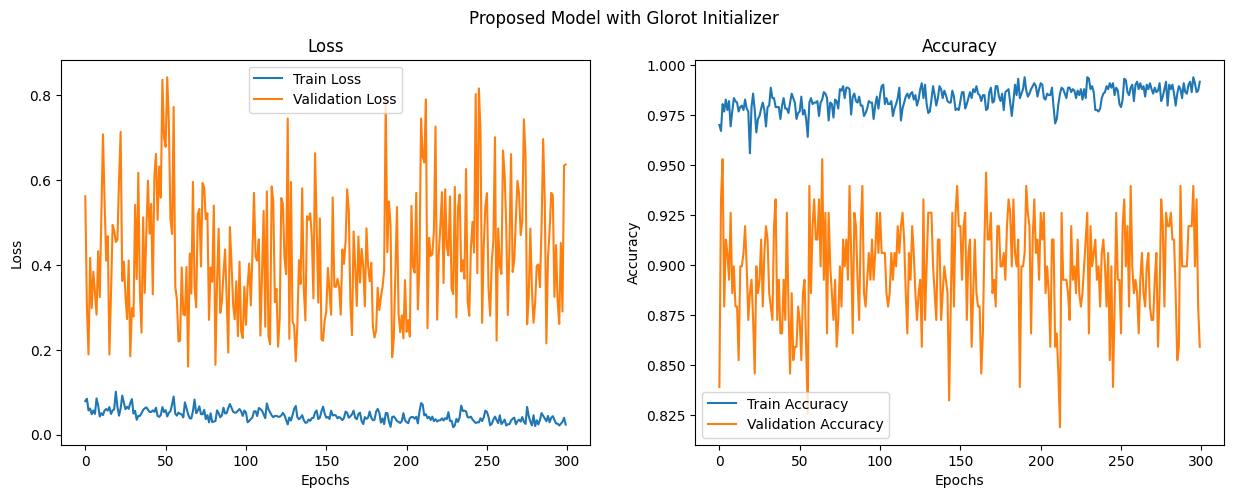

In [ ]:
model_name = 'Proposed Model with Glorot Initializer'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name, model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

# Train and Evaluate Proposed Model with Dropout and Glorot Initializer

Training Proposed Model with Droupout and Glorot Initializer...
Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5549
Epoch 1: val_loss improved from inf to 0.67591, saving model to best_Proposed Model with Droupout and Glorot Initializer.h5
21/21 [==============================] - 10s 133ms/step - loss: 0.6869 - accuracy: 0.5549 - val_loss: 0.6759 - val_accuracy: 0.5839
Epoch 2/300
 1/21 [>.............................] - ETA: 1s - loss: 0.6849 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.5833
Epoch 2: val_loss did not improve from 0.67591
21/21 [==============================] - 2s 85ms/step - loss: 0.6792 - accuracy: 0.5833 - val_loss: 0.6772 - val_accuracy: 0.5839
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.5810
Epoch 3: val_loss improved from 0.67591 to 0.67580, saving model to best_Proposed Model with Droupout and Glorot Initializer.h5
21/21 [==============================] - 2s 92ms/step - loss: 0.6705 - accuracy: 0.5810 - val_loss: 0.6758 - val_accuracy: 0.6107
Epoch 4/300
21/21 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.5900
Epoch 4: val_loss improved from 0.67580 to 0.67030, saving model to best_Proposed Model with Droupout and Glorot Initializer.h5
21/21 [==============================] - 3s 126ms/step - loss: 0.6728 - accuracy: 0.5900 - val_loss: 0.6703 - val_accuracy: 0.5839
Epoch 5/300
21/21 [==============

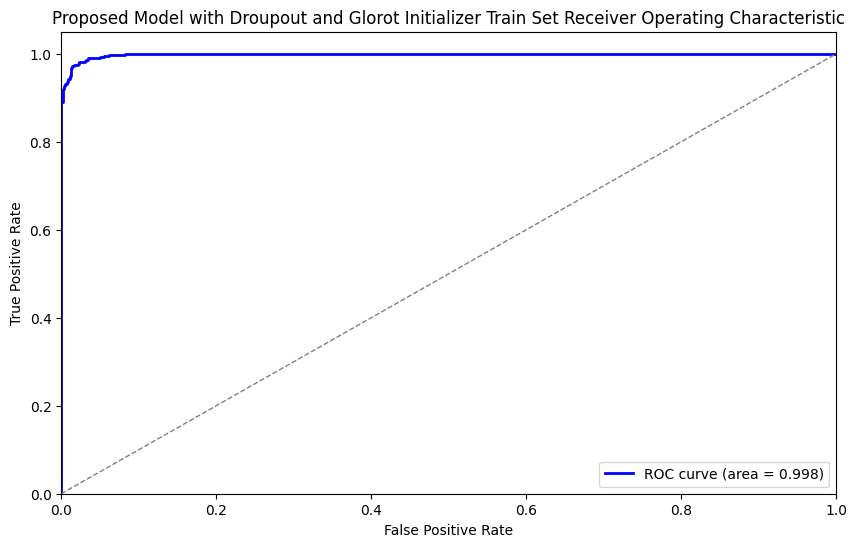

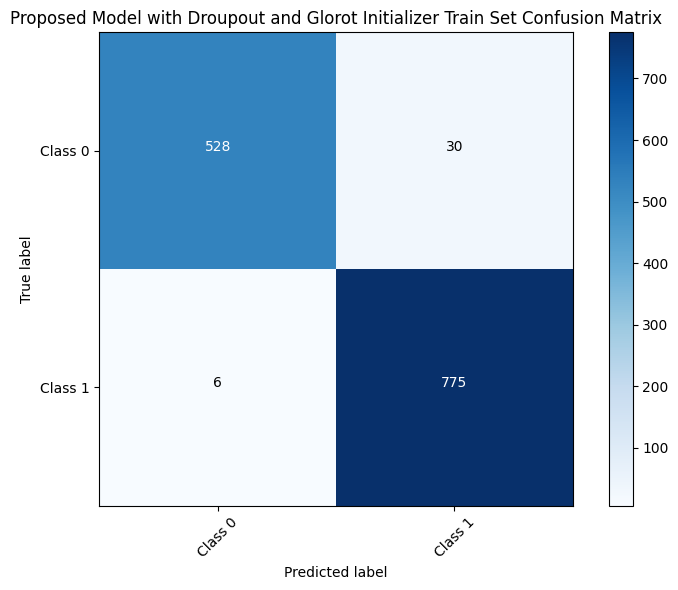

Accuracy: 97.31
Precision: 96.27
Recall: 99.23
F1 Score: 0.977
AUC: 0.998
Loss: 0.069
Evaluating Proposed Model with Droupout and Glorot Initializer on Validation set...
Test accuracy: 0.9530201554298401 Test loss: 0.17784316837787628
3/3 [==============================] - 0s 9ms/step


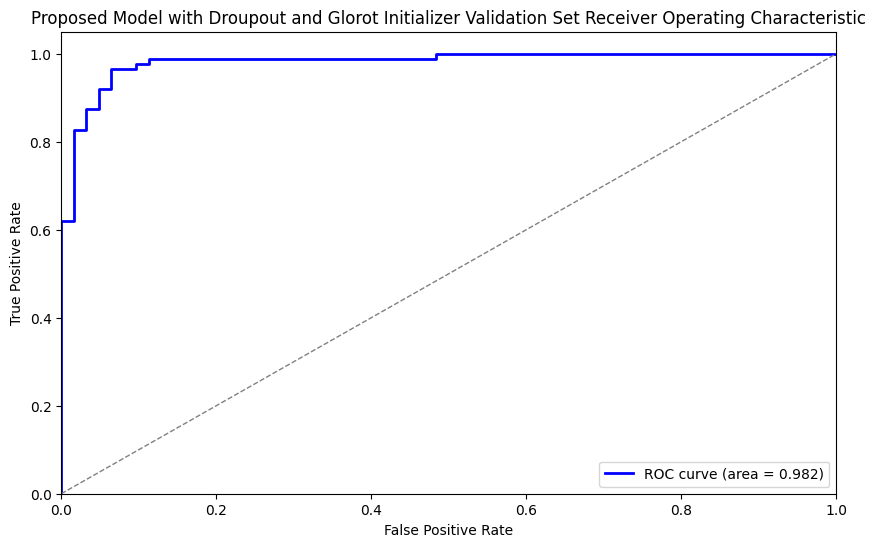

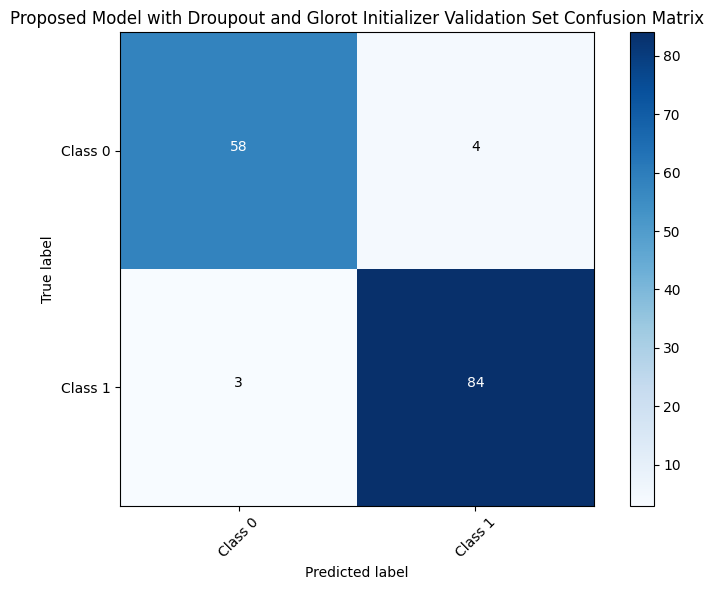

Accuracy: 95.30
Precision: 95.45
Recall: 96.55
F1 Score: 0.960
AUC: 0.982
Loss: 0.178
Evaluating Proposed Model with Droupout and Glorot Initializer on Test set...
Test accuracy: 0.9156626462936401 Test loss: 0.1870708018541336
3/3 [==============================] - 0s 12ms/step


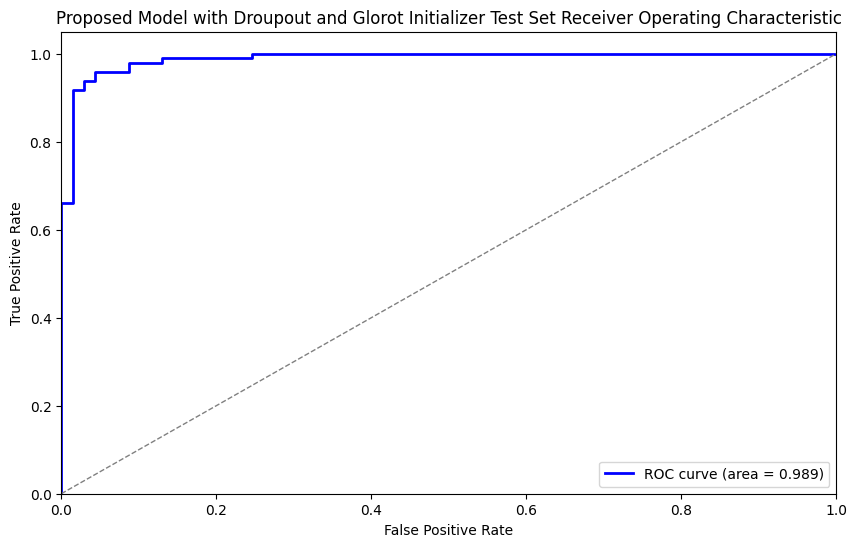

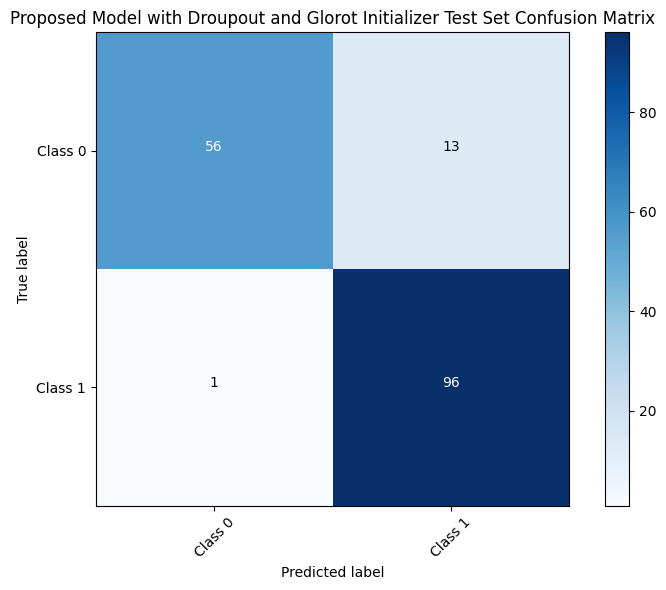

Accuracy: 91.57
Precision: 88.07
Recall: 98.97
F1 Score: 0.932
AUC: 0.989
Loss: 0.187
Plotting history for Proposed Model with Droupout and Glorot Initializer...


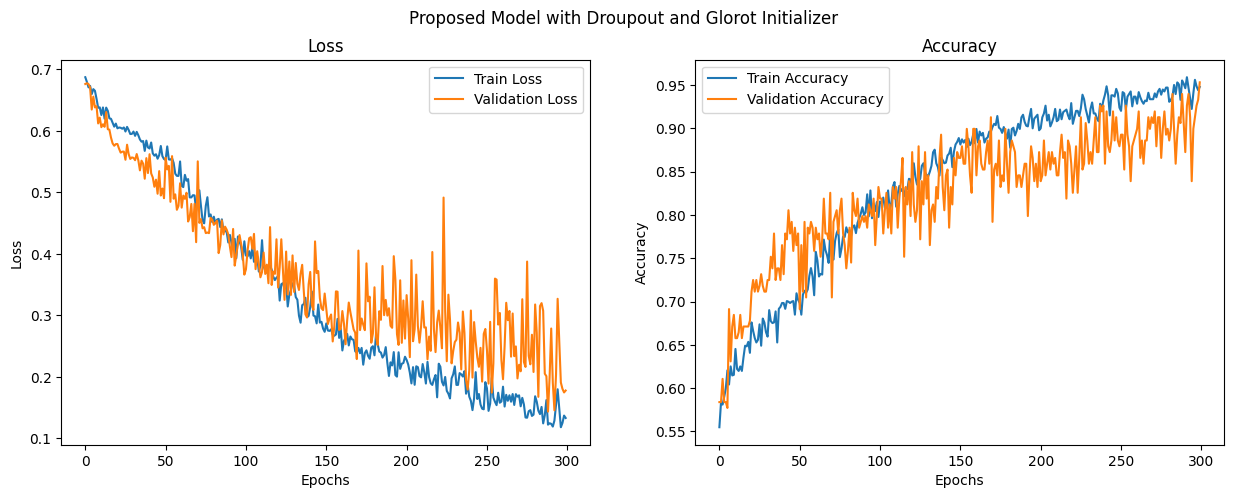

In [ ]:
model_name = 'Proposed Model with Droupout and Glorot Initializer'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name, model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

# Train and Evaluate with Differenct Percentages of Test Data

---



## 30 Percent

### Splitting the Data

In [ ]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

### Checking the Data Distribution

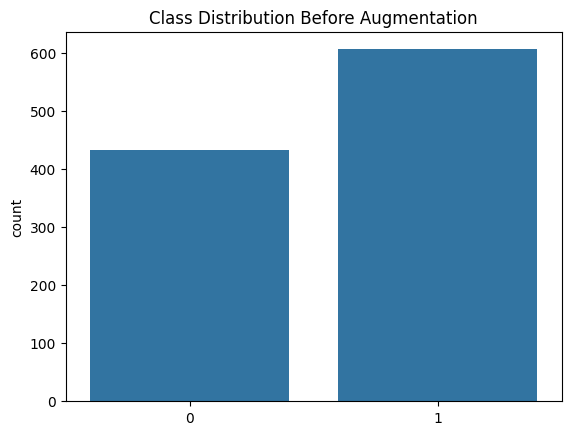

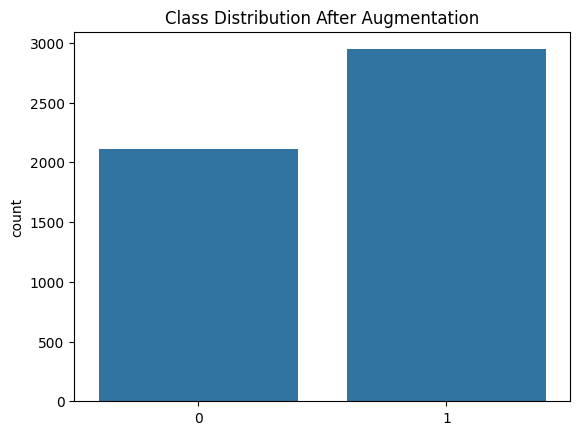

In [ ]:
# Display class distribution before augmentation
sns.countplot(x=np.argmax(y_train, 1))
plt.title('Class Distribution Before Augmentation')
plt.show()

batch_size = 64

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen_test = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_test = train_datagen_test.flow(X_train, y_train, batch_size=batch_size)

val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Display class distribution after augmentation
augmented_images, _ = next(train_generator)

augmented_labels = []
for _ in range((len(y_train)*5 // batch_size)+1):
    _, batch_labels = next(train_generator)
    augmented_labels.extend(batch_labels)
sns.countplot(x=np.argmax(augmented_labels, 1))
plt.title('Class Distribution After Augmentation')
plt.show()

### Train and Evaluate

Training Proposed Model with Droupout and Glorot Initializer...
Epoch 1/300
17/17 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9289
Epoch 1: val_loss improved from inf to 0.15879, saving model to best_Proposed Model with Droupout and Glorot Initializer 30 test.h5
17/17 [==============================] - 5s 146ms/step - loss: 0.1708 - accuracy: 0.9289 - val_loss: 0.1588 - val_accuracy: 0.9655
Epoch 2/300
 1/17 [>.............................] - ETA: 1s - loss: 0.0822 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9328
Epoch 2: val_loss improved from 0.15879 to 0.09977, saving model to best_Proposed Model with Droupout and Glorot Initializer 30 test.h5
17/17 [==============================] - 1s 83ms/step - loss: 0.1520 - accuracy: 0.9328 - val_loss: 0.0998 - val_accuracy: 0.9569
Epoch 3/300
17/17 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9318
Epoch 3: val_loss improved from 0.09977 to 0.07910, saving model to best_Proposed Model with Droupout and Glorot Initializer 30 test.h5
17/17 [==============================] - 1s 85ms/step - loss: 0.1655 - accuracy: 0.9318 - val_loss: 0.0791 - val_accuracy: 0.9828
Epoch 4/300
17/17 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9500
Epoch 4: val_loss did not improve from 0.07910
17/17 [==============================] - 1s 83ms/step - loss: 0.1266 - accuracy: 0.9500 - val_loss: 0.1673 - val_accuracy: 0.9310
Epoch 5/300
17/17 

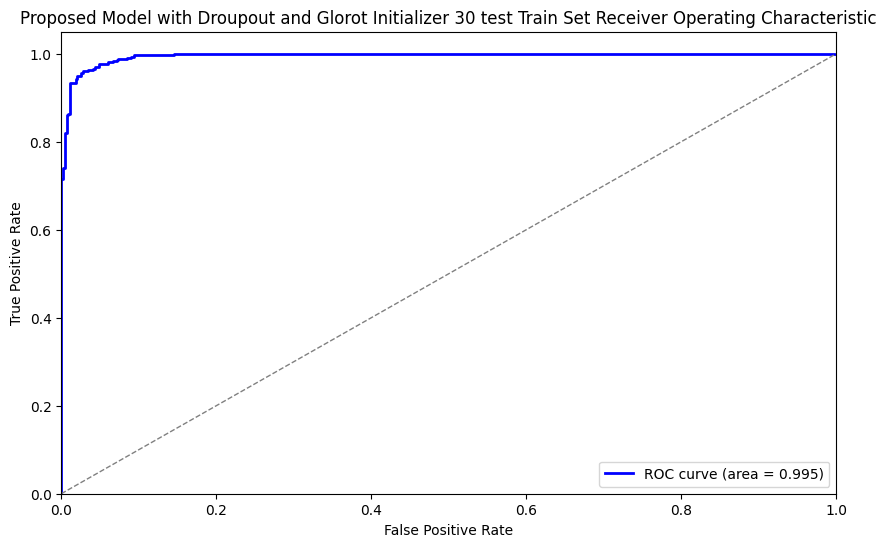

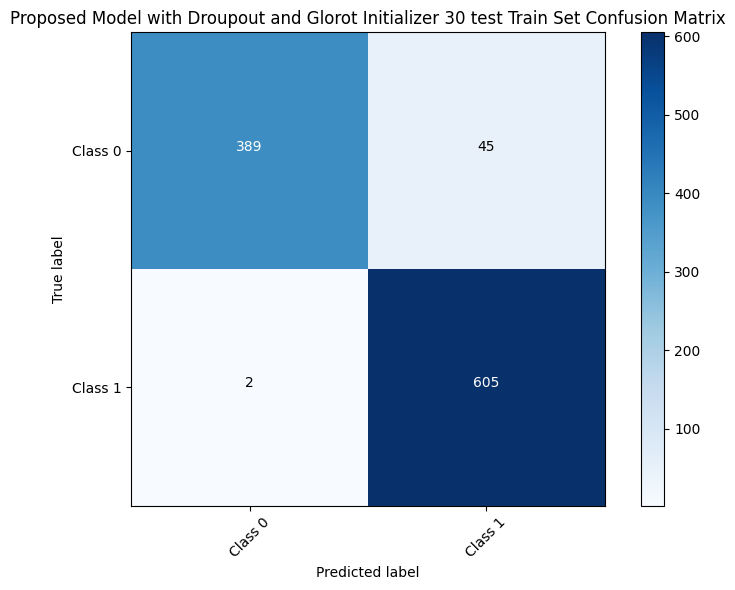

Accuracy: 95.49
Precision: 93.08
Recall: 99.67
F1 Score: 0.963
AUC: 0.995
Loss: 0.137
Evaluating Proposed Model with Droupout and Glorot Initializer on Validation set...
Test accuracy: 0.8793103694915771 Test loss: 0.5456362366676331
2/2 [==============================] - 0s 12ms/step


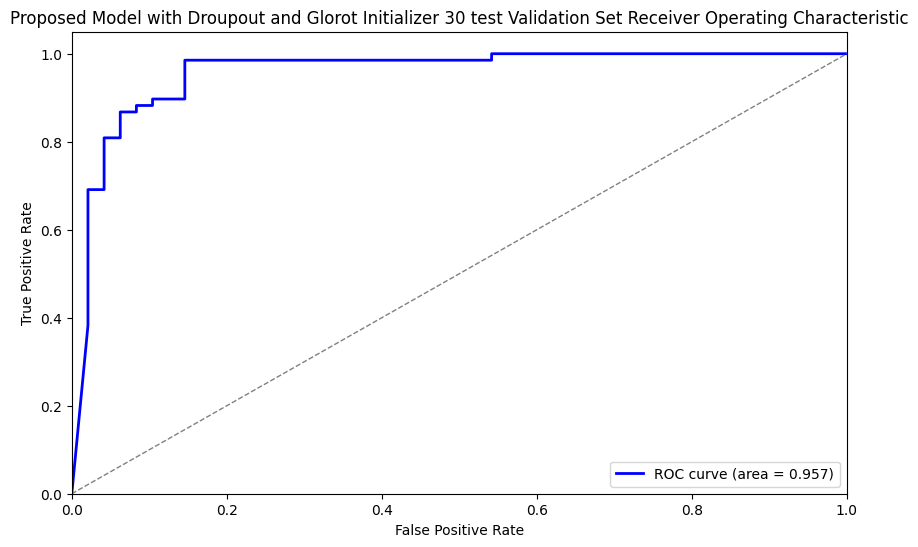

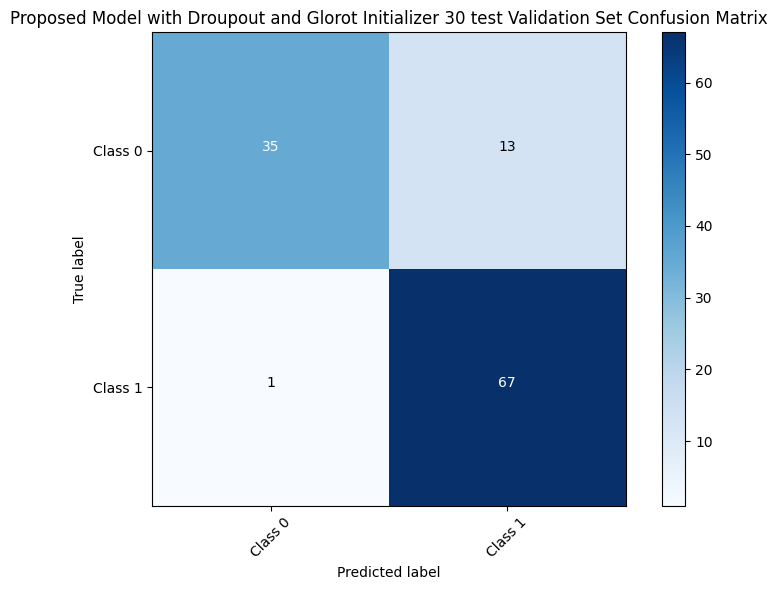

Accuracy: 87.93
Precision: 83.75
Recall: 98.53
F1 Score: 0.905
AUC: 0.957
Loss: 0.546
Evaluating Proposed Model with Droupout and Glorot Initializer on Test set...
Test accuracy: 0.8873239159584045 Test loss: 0.452388733625412
8/8 [==============================] - 0s 9ms/step


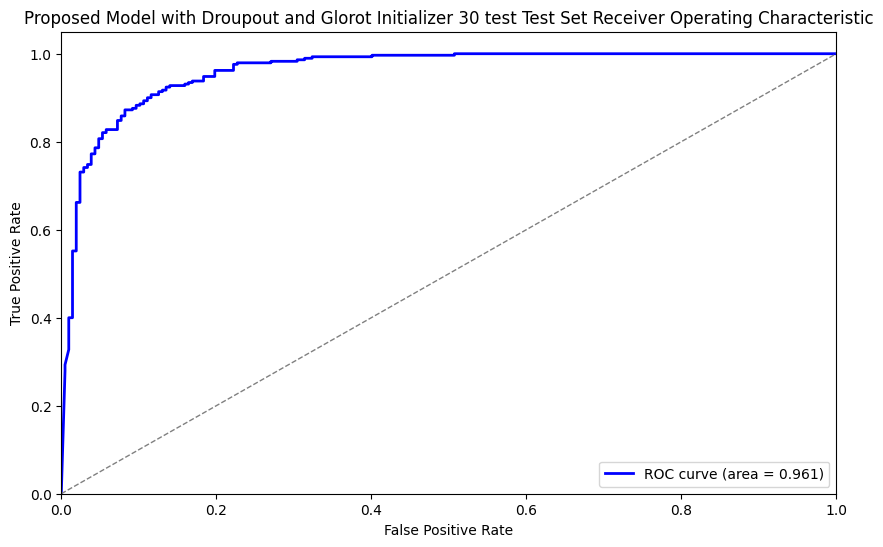

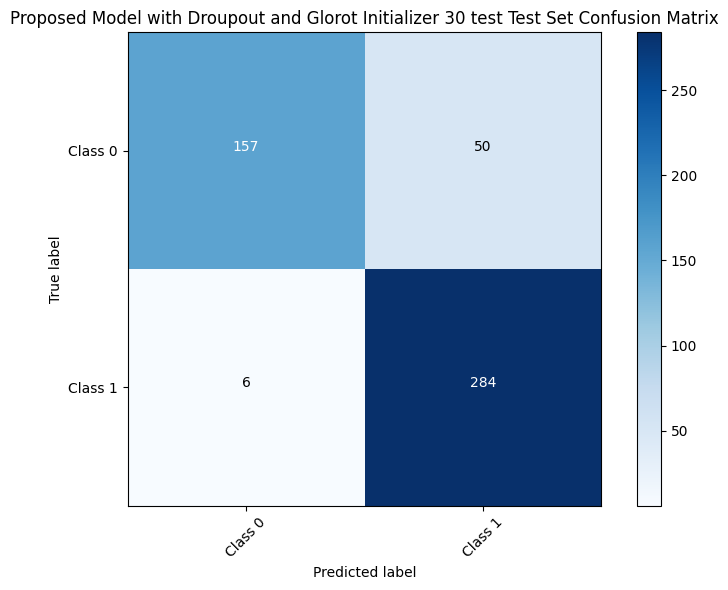

Accuracy: 88.73
Precision: 85.03
Recall: 97.93
F1 Score: 0.910
AUC: 0.961
Loss: 0.452
Plotting history for Proposed Model with Droupout and Glorot Initializer 30 test...


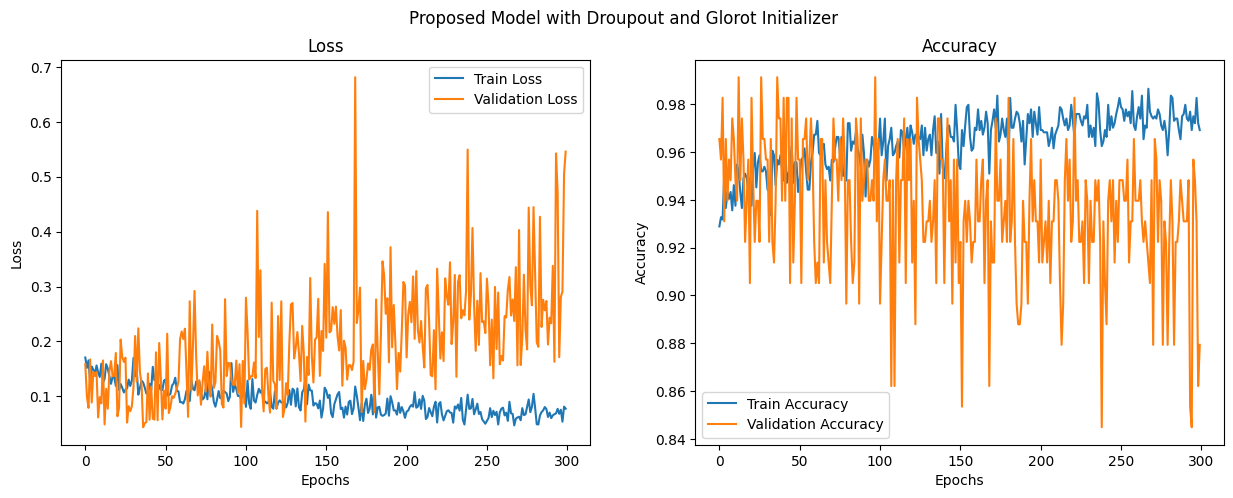

In [ ]:
model_name = 'Proposed Model with Droupout and Glorot Initializer'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name + ' 30 test', model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' 30 test' + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' 30 test' + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' 30 test' + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name + ' 30 test'}...")
plot_history(model_name, history)

## 50 Percent

### Splitting the Data

In [ ]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

### Checking the Data Distribution

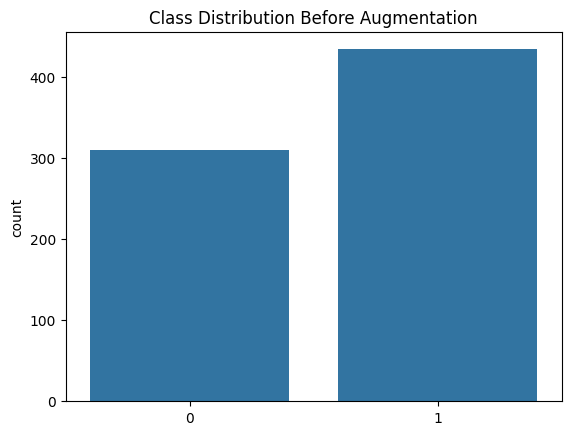

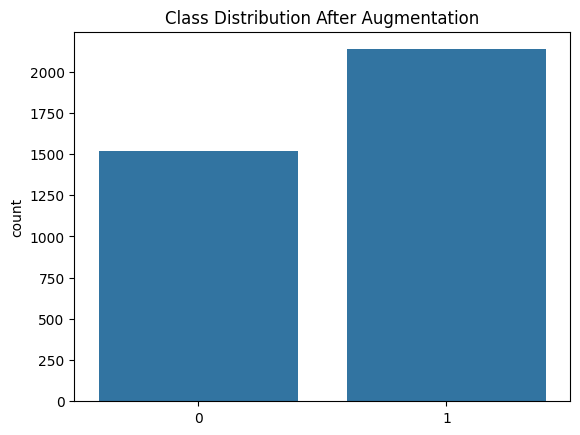

In [ ]:
# Display class distribution before augmentation
sns.countplot(x=np.argmax(y_train, 1))
plt.title('Class Distribution Before Augmentation')
plt.show()

batch_size = 64

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen_test = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_test = train_datagen_test.flow(X_train, y_train, batch_size=batch_size)

val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Display class distribution after augmentation
augmented_images, _ = next(train_generator)

augmented_labels = []
for _ in range((len(y_train)*5 // batch_size)+1):
    _, batch_labels = next(train_generator)
    augmented_labels.extend(batch_labels)
sns.countplot(x=np.argmax(augmented_labels, 1))
plt.title('Class Distribution After Augmentation')
plt.show()

### Train and Evaluate

Training Proposed Model with Droupout and Glorot Initializer...
Epoch 1/300
11/12 [==========================>...] - ETA: 0s - loss: 0.1154 - accuracy: 0.9647
Epoch 1: val_loss improved from inf to 0.07531, saving model to best_Proposed Model with Droupout and Glorot Initializer 50 test.h5
12/12 [==============================] - 4s 168ms/step - loss: 0.1220 - accuracy: 0.9597 - val_loss: 0.0753 - val_accuracy: 0.9639
Epoch 2/300
 1/12 [=>............................] - ETA: 1s - loss: 0.1045 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9731
Epoch 2: val_loss improved from 0.07531 to 0.02142, saving model to best_Proposed Model with Droupout and Glorot Initializer 50 test.h5
12/12 [==============================] - 1s 91ms/step - loss: 0.0735 - accuracy: 0.9731 - val_loss: 0.0214 - val_accuracy: 0.9880
Epoch 3/300
12/12 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9637
Epoch 3: val_loss improved from 0.02142 to 0.01457, saving model to best_Proposed Model with Droupout and Glorot Initializer 50 test.h5
12/12 [==============================] - 1s 125ms/step - loss: 0.0891 - accuracy: 0.9637 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 4/300
12/12 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9677
Epoch 4: val_loss improved from 0.01457 to 0.01166, saving model to best_Proposed Model with Droupout and Glorot Initializer 50 test.h5
12/12 [==============================] - 1s 108ms/step - l

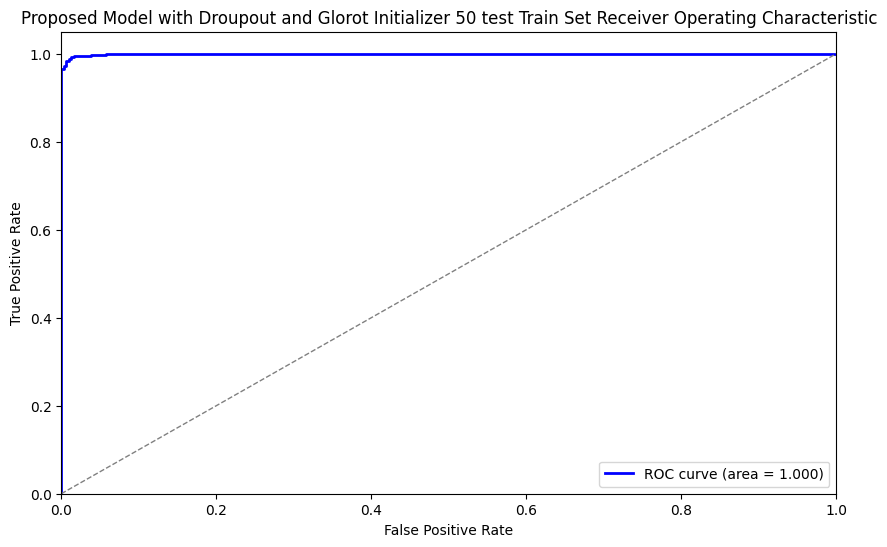

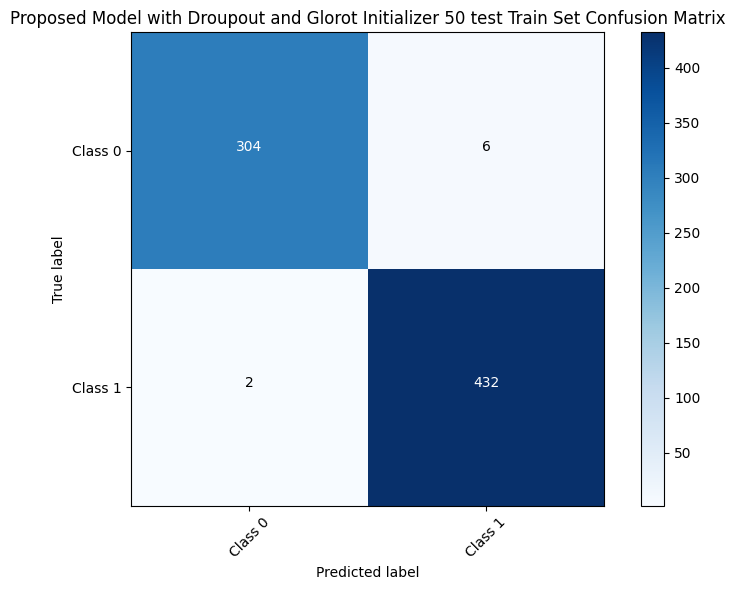

Accuracy: 98.92
Precision: 98.63
Recall: 99.54
F1 Score: 0.991
AUC: 1.000
Loss: 0.030
Evaluating Proposed Model with Droupout and Glorot Initializer on Validation set...
Test accuracy: 1.0 Test loss: 0.0198585893958807
2/2 [==============================] - 0s 9ms/step


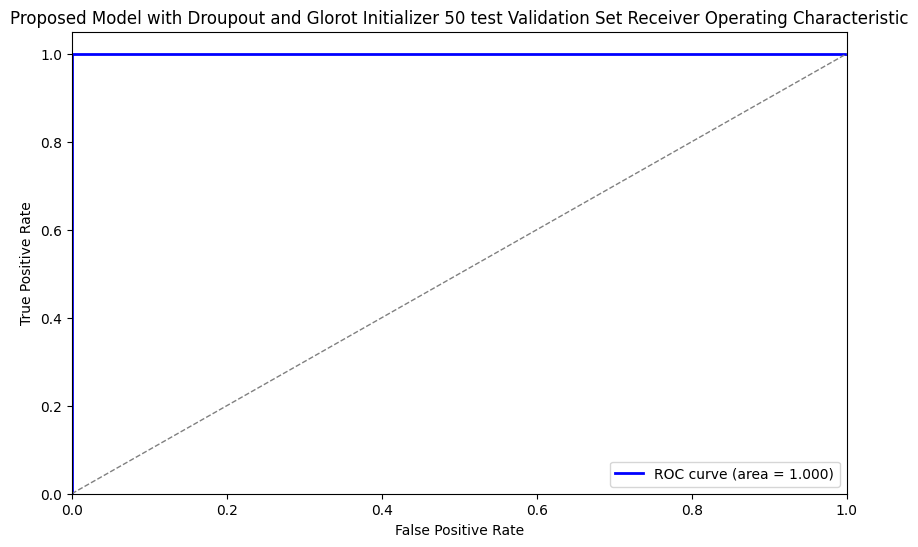

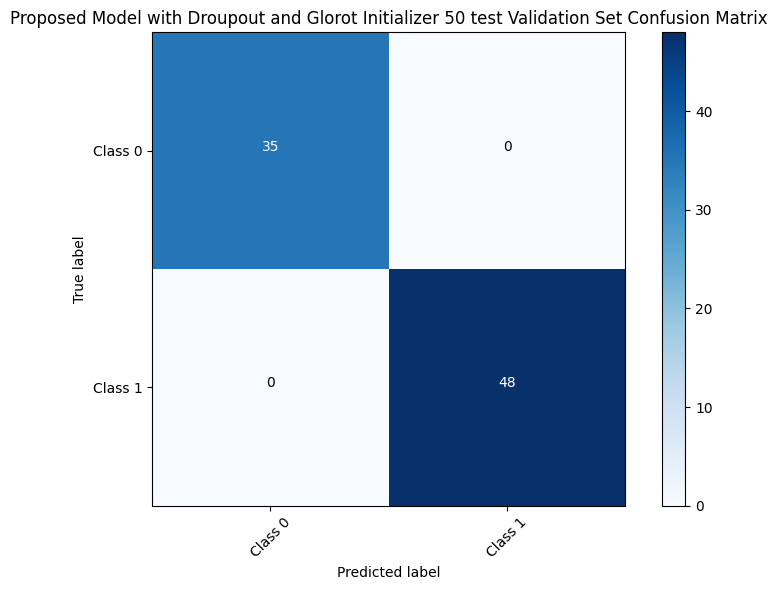

Accuracy: 100.00
Precision: 100.00
Recall: 100.00
F1 Score: 1.000
AUC: 1.000
Loss: 0.020
Evaluating Proposed Model with Droupout and Glorot Initializer on Test set...
Test accuracy: 0.9455864429473877 Test loss: 0.18071980774402618
13/13 [==============================] - 0s 7ms/step


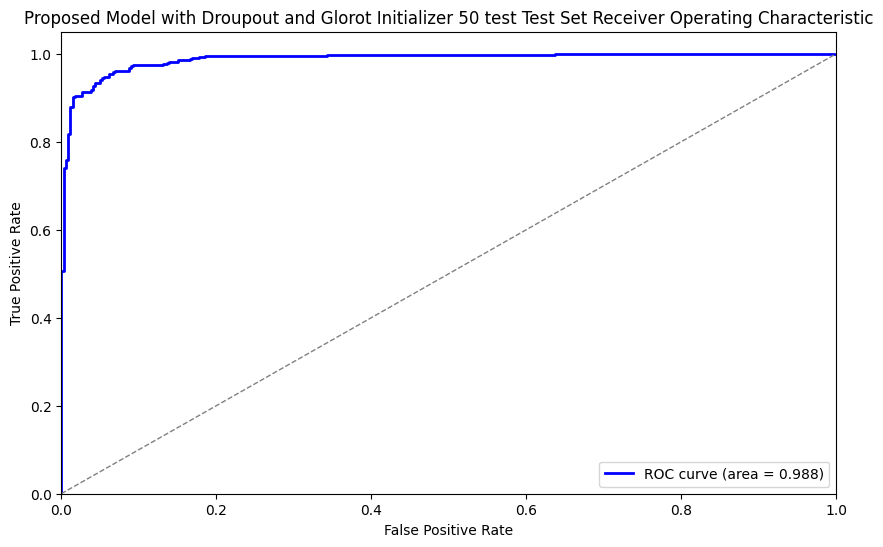

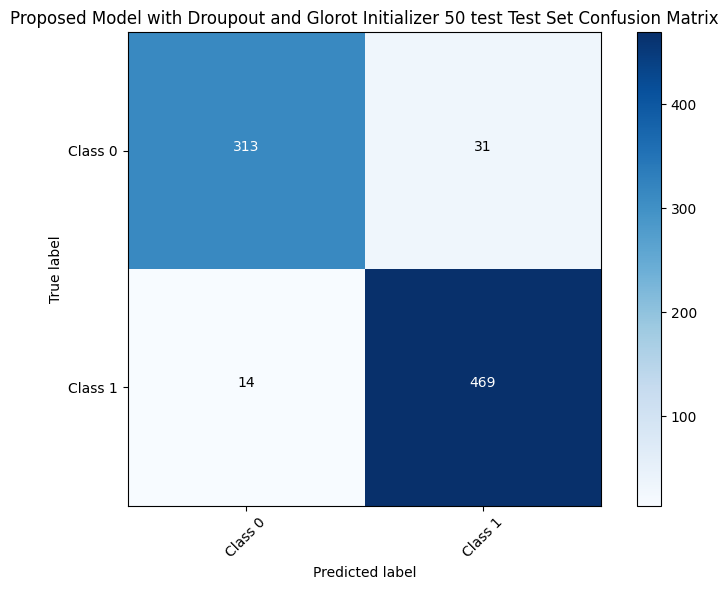

Accuracy: 94.56
Precision: 93.80
Recall: 97.10
F1 Score: 0.954
AUC: 0.988
Loss: 0.181
Plotting history for Proposed Model with Droupout and Glorot Initializer 50 test...


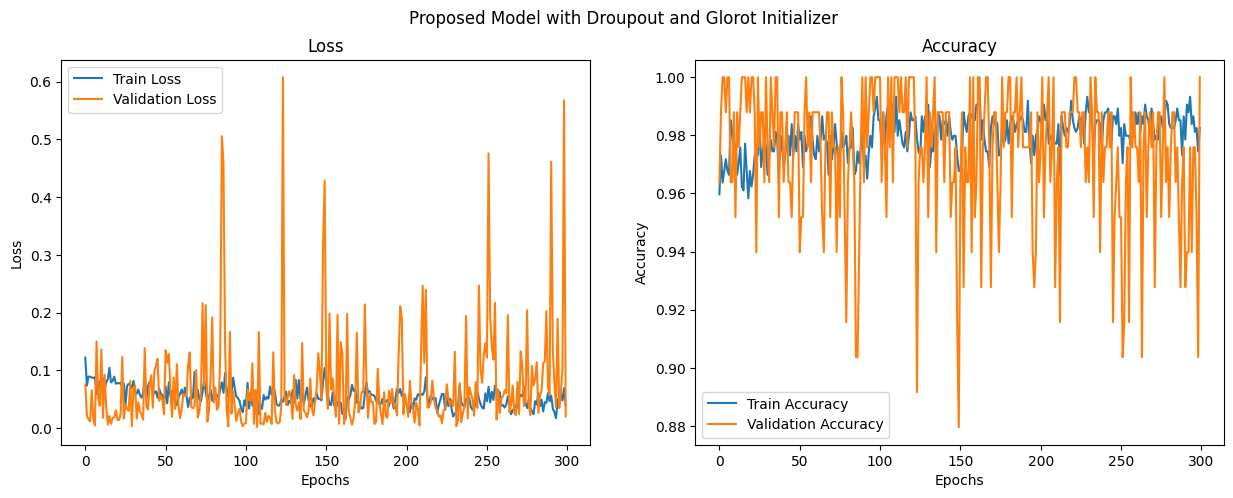

In [ ]:
model_name = 'Proposed Model with Droupout and Glorot Initializer'
model = models[model_name]

print(f"Training {model_name}...")
history = compile_and_train(model_name + ' 50 test', model, train_generator, val_generator)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' 50 test' + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' 50 test' + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' 50 test' + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name + ' 50 test'}...")
plot_history(model_name, history)